In [1]:
# basic stuff 
from scipy import stats, signal, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from google.colab import files
import os
import sklearn
import time
import json
import math
import statsmodels.api as sm

# !pip install mat73

# dim reduction and visualization
from sklearn.decomposition import PCA
# !pip install umap
# !pip install umap-learn
# import umap.umap_ as umap
from sklearn.manifold import TSNE

# torch stuff
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Miller_Lab/FIU/PopFR/')
sys.path.append('/content/drive/MyDrive/Miller_Lab/FIU/xds_python/')

In [4]:
from xds import lab_data
import joint_angles

# Notebook Description - Data Preprocessing and Network Architecture

All neural data are in .mat files ("xds" files compatible with the package imported below) stored on my google drive. Jarvis kinematic data are stored on my local computer in csv's - it is necessary to upload every time you start a new runtime.

### Preprocessing - Jarvis Kinematics Data

Kinematics data were obtained from the prediction software Jarvis, which takes in videos as input and outputs 3D keypoint predictions, along with their likelihoods, in a csv. There are 23 keypoints on the monkey's hand, including fingertips, joints, palm, and wrist. Videos were captured at a rate of 30Hz (1 frame/33.3ms). Likelihoods were removed, producing a csv of shape num_frames x 69 (23 keypoints in 3D -> 69 columns). For the time being, csv's with any NaN values are ignored, but those with a small number of NaN's will likely be interpolated within the bounds of the Nyquist criterion.

### Preprocessing - Neural Data

The main field of interest in the xds files is "spike_counts". This field is an array containing spike information for each of the sorted units - 1's and 0's where threshold crossings do and do not occur. This data was preprocessed in the following way:
- Sorting was done before creating xds files. This was done manually using the OfflineSorter software to identify "units" - these can more or less be thought of as individual neurons. Electrodes often pick up signals from multiple neurons simultaneously, and distinguishing these neurons from one another might be helpful for our encoding project (note - this is not usually done for decoding, where neural signals are inputs, and kinematics are outputs). 
- xds files are now created, containing the spike_counts field. As mentioned, this is an array containing 1's and 0's every 1ms. These spikes are binned to 33ms (1's and 0's are summed in 33ms intervals), and then divided by 33ms to produce firing rates. Each element of the array is now the average number of spikes per ms across a 33ms interval. 33ms was chosen in accordance with the frame rate of the cameras used for the videos; this bin size reduces the number of neural data points to exactly the number of kinematic data points.
- Firing rates are now smoothed with a Gaussian filter. This is a standard practice in neuroscience - it produces a moving weighted average (where the weights are determined by a Gaussian distribution) and mitigates the effects of imperfections in the data collection process.



### Data batches and Network Architecture

- Data batching
  - Each session was broken into chunks of length 100. Therefore, a session with 18000 frames produces a dataset with 180 instances, each with length 100.
- Network Architecture
  - Temporal convolutional network with varying number of convolutional layers, ReLU, and single linear readout layer.

# Get Data

In [5]:
keypoint_list_names = ['Pinky_T_x','Pinky_T_y','Pinky_T_z',
                       'Pinky_D_x','Pinky_D_y','Pinky_D_z',
                       'Pinky_M_x','Pinky_M_y','Pinky_M_z',
                       'Pinky_P_x','Pinky_P_y','Pinky_P_z',
                       'Ring_T_x','Ring_T_y','Ring_T_z',
                       'Ring_D_x','Ring_D_y','Ring_D_z',
                       'Ring_M_x','Ring_M_y','Ring_M_z',
                       'Ring_P_x','Ring_P_y','Ring_P_z',
                       'Middle_T_x','Middle_T_y','Middle_T_z',
                       'Middle_D_x','Middle_D_y','Middle_D_z',
                       'Middle_M_x','Middle_M_y','Middle_M_z',
                       'Middle_P_x','Middle_P_y','Middle_P_z',
                       'Index_T_x','Index_T_y','Index_T_z',
                       'Index_D_x','Index_D_y','Index_D_z',
                       'Index_M_x','Index_M_y','Index_M_z',
                       'Index_P_x','Index_P_y','Index_P_z',
                       'Thumb_T_x','Thumb_T_y','Thumb_T_z',
                       'Thumb_D_x','Thumb_D_y','Thumb_D_z',
                       'Thumb_M_x','Thumb_M_y','Thumb_M_z',
                       'Thumb_P_x','Thumb_P_y','Thumb_P_z',
                       'Palm_x','Palm_y','Palm_z',
                       'Wrist_U_x','Wrist_U_y','Wrist_U_z',
                       'Wrist_R_x','Wrist_R_y','Wrist_R_z']
joint_names_list = ['Pinky DIP','Pinky PIP','Pinky MCP',
                    'Ring DIP','Ring PIP','Ring MCP',
                    'Middle DIP','Middle PIP','Middle MCP',
                    'Index DIP','Index PIP','Index MCP',
                    'Thumb DIP','Thumb PIP','Thumb MCP']

In [7]:
jarvispreds20210712 = np.genfromtxt('20210712_data3D.csv', delimiter = ',')
jarvispreds20210814 = np.genfromtxt('20210814_data3D.csv', delimiter = ',')
jarvispreds20211105 = np.genfromtxt('20211105_data3D.csv', delimiter = ',')
jarvispreds20220203 = np.genfromtxt('20220203_data3D.csv', delimiter = ',')
jarvispreds20220210_001 = np.genfromtxt('20220210uc_data3D.csv', delimiter = ',')
jarvispreds20220210_002 = np.genfromtxt('20220210pipe_data3D.csv', delimiter = ',')
jarvispreds20220224 = np.genfromtxt('20220224_data3D.csv', delimiter = ',')
jarvispreds20220405_002 = np.genfromtxt('20220405uc_data3D.csv', delimiter = ',')

In [10]:
jarvispreds20220309 = np.genfromtxt('20220309stick_data3D.csv', delimiter = ',')

In [27]:
jarvispreds_list_untrimmed = [jarvispreds20210712,jarvispreds20210814,jarvispreds20211105,jarvispreds20220203 
                    ,jarvispreds20220210_001,jarvispreds20220210_002,jarvispreds20220224, jarvispreds20220405_002]

In [28]:
jarvispreds20220309.shape

(18000, 92)

#### Get relevant columns from jarvis

In [29]:
# Remove likelihoods from jarvis csv's - they are every 4th column
# Trim videos to remove extra frames
jarvispreds_list = []
for jarvispred_untrimmed in jarvispreds_list_untrimmed:
    x = np.arange(92)
    liks = (np.arange(0, x.size+1, 4) -1)[1:]
    x = np.delete(x, liks)
    shape_before = jarvispred_untrimmed.shape
    num_frames = jarvispred_untrimmed.shape[0]
    num_frames_trimmed = int(num_frames/18000)*18000
    jarvispred_trimmed = jarvispred_untrimmed[:num_frames_trimmed, x]
    shape_after = jarvispred_trimmed.shape
    jarvispreds_list.append(jarvispred_trimmed)
    print('Shape before: {}, shape after: {}'.format(shape_before, shape_after))

Shape before: (37455, 92), shape after: (36000, 69)
Shape before: (55374, 92), shape after: (54000, 69)
Shape before: (36930, 92), shape after: (36000, 69)
Shape before: (18000, 92), shape after: (18000, 69)
Shape before: (18475, 92), shape after: (18000, 69)
Shape before: (18000, 92), shape after: (18000, 69)
Shape before: (18464, 92), shape after: (18000, 69)
Shape before: (18000, 92), shape after: (18000, 69)


In [19]:
binnedsortedspikes20210712 = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFR/neuraldata/','20210712_Pop_FR_01.mat')
binnedsortedspikes20210814 = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFR/neuraldata/','20210814_Pop_FR_001.mat')
binnedsortedspikes20211105 = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFR/neuraldata/','20211105_Pop_FR_001.mat')
binnedsortedspikes20220203 = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFR/neuraldata/','20220203_Pop_FR_003.mat')
binnedsortedspikes20220210_001 = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFR/neuraldata/','20220210_Pop_FR_001.mat')
binnedsortedspikes20220210_002 = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFR/neuraldata/','20220210_Pop_FR_002.mat')
binnedsortedspikes20220224 = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFR/neuraldata/','20220224_Pop_FR_001.mat')
binnedsortedspikes20220405_002 = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFR/neuraldata/','20220405_Pop_FR_002.mat')

In [16]:
mat_20220309 = io.loadmat('new_labels_proc.mat')
input_20220309 = mat_20220309['data'][0][0][-4]
output_20220309 = mat_20220309['data'][0][0][-1]

In [23]:
date_list = ['20210712','20210814','20211105', '20220203','20220210_001','20220210_002',
              '20220224','20220405','20220309']

In [26]:
neuraldata_list = [binnedsortedspikes20210712,binnedsortedspikes20210814,binnedsortedspikes20211105, 
                  binnedsortedspikes20220203,binnedsortedspikes20220210_001,binnedsortedspikes20220210_002,
                  binnedsortedspikes20220224,binnedsortedspikes20220405_002]

In [24]:
for binnedsortedspikes  in neuraldata_list:
    print(binnedsortedspikes.get_meta())

{'monkey_name': 'Pop', 'hand': 'Left', 'task_name': 'FR', 'duration': 1200.0040000000001, 'collect_date': '2021/7/12 20:17:2.453', 'raw_file_name': '20210712_Pop_FR_01', 'array': 'M1', 'processed_time': '05-Dec-2022'}
{'monkey_name': 'Pop', 'hand': 'Left', 'task_name': 'FR', 'duration': 1800.0095, 'collect_date': '2021/8/14 18:45:31.170', 'raw_file_name': 'Pop_20210814_FR_001', 'array': 'M1', 'processed_time': '05-Dec-2022'}
{'monkey_name': 'Pop', 'hand': 'Left', 'task_name': 'FR', 'duration': 1200.0040000000001, 'collect_date': '2021/11/5 21:5:8.218', 'raw_file_name': '20211105_Pop_FR_001', 'array': 'M1', 'processed_time': '08-Dec-2022'}
{'monkey_name': 'Pop', 'hand': 'Left', 'task_name': 'FR', 'duration': 600.0095, 'collect_date': '2022/2/3 21:43:57.717', 'raw_file_name': '20220203_Pop_FR_003', 'array': 'M1', 'processed_time': '05-Dec-2022'}
{'monkey_name': 'Pop', 'hand': 'Left', 'task_name': 'FR', 'duration': 600.0095, 'collect_date': '2022/2/10 22:16:49.778', 'raw_file_name': '2022

In [30]:
# Check for nans in neural data
for i, (binnedsortedspikes, jarvispred) in enumerate(zip(neuraldata_list, jarvispreds_list)):
    date = date_list[i]
    num_neural_nans = np.sum(np.isnan(binnedsortedspikes.spike_counts))
    print('DATE: {} \nNeural num nans: {}\n'\
          .format(date, num_neural_nans))

DATE: 20210712 
Neural num nans: 0

DATE: 20210814 
Neural num nans: 0

DATE: 20211105 
Neural num nans: 0

DATE: 20220203 
Neural num nans: 0

DATE: 20220210_001 
Neural num nans: 0

DATE: 20220210_002 
Neural num nans: 0

DATE: 20220224 
Neural num nans: 0

DATE: 20220405 
Neural num nans: 0



In [32]:
np.sum(np.isnan(jarvispreds20220309)), np.sum(np.isnan(output_20220309))

(0, 0)

In [33]:
jarvispreds20220309.shape, output_20220309.shape

((18000, 92), (17969, 96))

#### Keep only those without NaNs

In [19]:
# Check for nans in jarvis csv's and keep only those with non-nan values
jarvispreds_list_nonans = []
neuraldata_list_nonans = []
date_list_nonans = []
for i, (binnedsortedspikes, jarvispred) in enumerate(zip(neuraldata_list, jarvispreds_list)):
    date = date_list[i]
    num_jarv_nans = np.sum(np.isnan(jarvispred))
    print('DATE: {} \nNeural File Time Duration: {} \nNeural File Spikes Length: {} \nJarvis Preds Length: {} \nJarvis Preds num nans: {}\n'\
          .format(date, binnedsortedspikes.get_meta()['duration'], binnedsortedspikes.spike_counts.shape, jarvispred.shape[0], num_jarv_nans))
    if num_jarv_nans == 0:
        print('KEPT - NO NANS: {}\n'.format(date))
        jarvispreds_list_nonans.append(jarvispred)
        neuraldata_list_nonans.append(binnedsortedspikes)
        date_list_nonans.append(date)

DATE: 20210712 
Neural File Time Duration: 1200.0040000000001 
Neural File Spikes Length: (1200005, 142) 
Jarvis Preds Length: 36000 
Jarvis Preds num nans: 690

DATE: 20210814 
Neural File Time Duration: 1800.0095 
Neural File Spikes Length: (1800010, 145) 
Jarvis Preds Length: 54000 
Jarvis Preds num nans: 81696

DATE: 20211105 
Neural File Time Duration: 1200.0040000000001 
Neural File Spikes Length: (1200005, 113) 
Jarvis Preds Length: 36000 
Jarvis Preds num nans: 276

DATE: 20220203 
Neural File Time Duration: 600.0095 
Neural File Spikes Length: (600010, 44) 
Jarvis Preds Length: 18000 
Jarvis Preds num nans: 0

KEPT - NO NANS: 20220203

DATE: 20220210_001 
Neural File Time Duration: 600.0095 
Neural File Spikes Length: (600010, 62) 
Jarvis Preds Length: 18000 
Jarvis Preds num nans: 0

KEPT - NO NANS: 20220210_001

DATE: 20220210_002 
Neural File Time Duration: 600.0095 
Neural File Spikes Length: (600010, 62) 
Jarvis Preds Length: 18000 
Jarvis Preds num nans: 0

KEPT - NO NAN

20210712 and 20211105 have small number of nans... linearly interpolate them

In [20]:
nan_rows_20210712 = np.unique(np.where(np.isnan(jarvispreds_list[0]))[0])
nan_rows_20211105 = np.unique(np.where(np.isnan(jarvispreds_list[2]))[0])
good_rows_20210712 = np.unique(np.where(~np.isnan(jarvispreds_list[0]))[0])
good_rows_20211105 = np.unique(np.where(~np.isnan(jarvispreds_list[2]))[0])

In [21]:
nan_rows_20210712, nan_rows_20211105

(array([233, 234, 235, 236, 238, 249, 250, 251, 252, 255]),
 array([  249,   251, 12595, 23798]))

In [22]:
def find_nan_windows(arr):
    windows = []
    i = 0
    while i < arr.shape[0]:
        if np.isnan(arr[i,:]).any():
            good_row_start = i-1
            j = 0
            while np.isnan(arr[i+j,:]).any():
                j+=1
            good_row_end = i+j
            i = good_row_end
            window = (good_row_start, good_row_end)
            windows.append(window)
        else:
            i +=1
    return(windows)

def linear_interpolation(arr, windows):
    arr_copy = np.copy(arr)
    for pair in windows:
        start, finish = arr_copy[pair[0],:],arr_copy[pair[1],:]
        div = pair[1]-pair[0]
        add = (finish-start)/div
        i = pair[0]+1
        while i<pair[1]:
            diff = i-pair[0]
            arr_copy[i,:] = diff * add
            i += 1
    return(arr_copy)

In [23]:
lin_int_20210712 = linear_interpolation(jarvispreds_list[0], find_nan_windows(jarvispreds_list[0]))
lin_int_20211105 = linear_interpolation(jarvispreds_list[2], find_nan_windows(jarvispreds_list[2]))

In [24]:
np.unique(np.where(np.isnan(lin_int_20210712))[0])

array([], dtype=int64)

It worked!

In [25]:
(lin_int_20210712[good_rows_20210712] == jarvispreds_list[0][good_rows_20210712]).all(), (lin_int_20211105[good_rows_20211105] == jarvispreds_list[2][good_rows_20211105]).all()

(True, True)

In [26]:
jarvispreds_list_nonans.append(lin_int_20210712)
jarvispreds_list_nonans.append(lin_int_20211105)
neuraldata_list_nonans.append(neuraldata_list[0])
neuraldata_list_nonans.append(neuraldata_list[2])
date_list_nonans.append('20210712')
date_list_nonans.append('20211105')

In [27]:
# bin spike counts, convert to firing rates, and smooth with gaussian filter (stand. dev. = 2xbin_size)
bin_size = 1/30
for date, binnedsortedspikes in zip(date_list_nonans, neuraldata_list_nonans):
    print(date)
    print('Shape before binning+smoothing is: {}'.format(binnedsortedspikes.spike_counts.shape))
    binnedsortedspikes.update_bin_data(bin_size)                                      #bin
    binnedsortedspikes.spike_counts = binnedsortedspikes.spike_counts/bin_size        #convert to firing rates
    binnedsortedspikes.smooth_binned_spikes(bin_size, 'gaussian', bin_size*2)         #smooth
    print('Shape after binning+smoothing is: {}\n'.format(binnedsortedspikes.spike_counts.shape))

20220203
Shape before binning+smoothing is: (600010, 44)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (18001, 44)

20220210_001
Shape before binning+smoothing is: (600010, 62)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (18001, 62)

20220210_002
Shape before binning+smoothing is: (600010, 62)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (18001, 62)

20220224
Shape before binning+smoothing is: (600010, 108)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (18001, 108)

20210712
Shape before binning+smoothing is: (1200005, 142)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (36001, 142)

20211105
Shape before binning+smoothing is: (1200005, 113)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after 

# Data Visualization

In [28]:
for i in range(len(neuraldata_list_nonans)):
    date = neuraldata_list_nonans[i].get_meta()['collect_date']
    print(date)

2022/2/3 21:43:57.717
2022/2/10 22:16:49.778
2022/2/10 22:29:3.268
2022/2/24 21:2:12.116
2021/7/12 20:17:2.453
2021/11/5 21:5:8.218


In [29]:
def visualize_neuraloutputs_histogram(dataset, nrows, ncols, figsize):
    print('Below 100 Hz is generally indicative of good data quality.')
    date = dataset.get_meta()['collect_date']
    print(date)
    fig, ax = plt.subplots(nrows = nrows, ncols = ncols)
    fig.set_size_inches(30, 50)
    # fig.suptitle('Session Dataset {}'.format(dataset.session_num))
    fig.tight_layout(pad=3.0)
    fig.subplots_adjust(top=0.95)
    for i in range(nrows*ncols):
        j = math.floor(i/ncols)
        k = i%ncols
        if (date not in ['2022/2/24 21:2:12.116','2021/7/12 20:17:2.453','2021/11/5 21:5:8.218']) and (i ==(nrows*ncols -1)):
            ax[j][k].hist(np.zeros(dim_vals.shape[0]), bins = 300)
        else:
            dim_vals = dataset.spike_counts[:,i]
            ax[j][k].hist(dim_vals, bins = 300)
        # dim_vals = dataset[:,i]
        # ax[j][k].hist(dim_vals, bins = 300)
        ax[j][k].set_title('Electrode {}'.format(i))
        ax[j][k].set_xlabel('Firing Rate (Hz)')
        ax[j][k].set_ylabel('Count')
      
    plt.show()

In [30]:
for neuraldata in neuraldata_list_nonans:
    print(neuraldata.spike_counts.shape, neuraldata.get_meta()['collect_date'])

(18001, 44) 2022/2/3 21:43:57.717
(18001, 62) 2022/2/10 22:16:49.778
(18001, 62) 2022/2/10 22:29:3.268
(18001, 108) 2022/2/24 21:2:12.116
(36001, 142) 2021/7/12 20:17:2.453
(36001, 113) 2021/11/5 21:5:8.218


In [54]:
hist_shapes_list = [(9,5),(9,7),(9,7),(12,9),(14,10),(14,8)]
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
for i, neuraldata in enumerate(neuraldata_list_nonans):
    nrows, ncols = hist_shapes_list[i]
    visualize_neuraloutputs_histogram(neuraldata, nrows, ncols, (70,30))

Output hidden; open in https://colab.research.google.com to view.

DATE: 20220203 
Neural File Time Duration: 600.0095 
Neural File Spikes Shape: (18001, 44) 
Jarvis Preds Shape: (18000, 69) 
Jarvis Preds num nans: 0

Keypoint Position Variance PC1: 0.4984, Keypoint Position Variance PC2: 0.3177, Variance PC1+PC2: 0.8161
Neural Variance PC1: 0.4939, Neural Variance PC2: 0.0916, Variance PC1+PC2: 0.5855


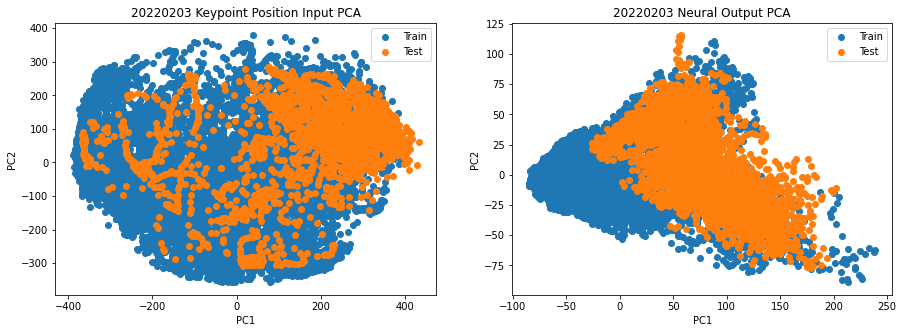



DATE: 20220210_001 
Neural File Time Duration: 600.0095 
Neural File Spikes Shape: (18001, 62) 
Jarvis Preds Shape: (18000, 69) 
Jarvis Preds num nans: 0

Keypoint Position Variance PC1: 0.5451, Keypoint Position Variance PC2: 0.3356, Variance PC1+PC2: 0.8807
Neural Variance PC1: 0.2238, Neural Variance PC2: 0.1374, Variance PC1+PC2: 0.36119999999999997


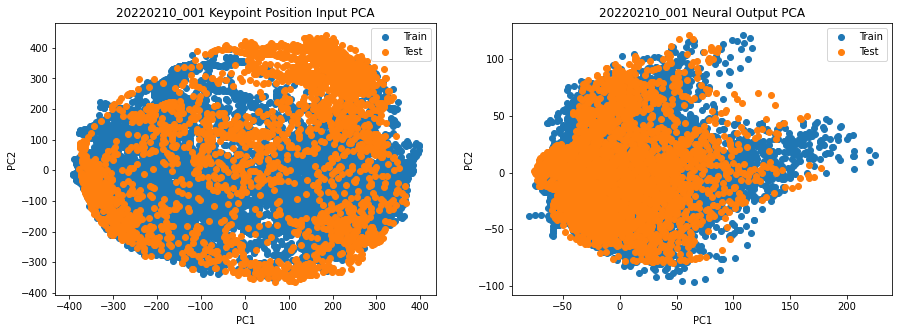



DATE: 20220210_002 
Neural File Time Duration: 600.0095 
Neural File Spikes Shape: (18001, 62) 
Jarvis Preds Shape: (18000, 69) 
Jarvis Preds num nans: 0

Keypoint Position Variance PC1: 0.7581, Keypoint Position Variance PC2: 0.1396, Variance PC1+PC2: 0.8976999999999999
Neural Variance PC1: 0.2088, Neural Variance PC2: 0.1394, Variance PC1+PC2: 0.3482


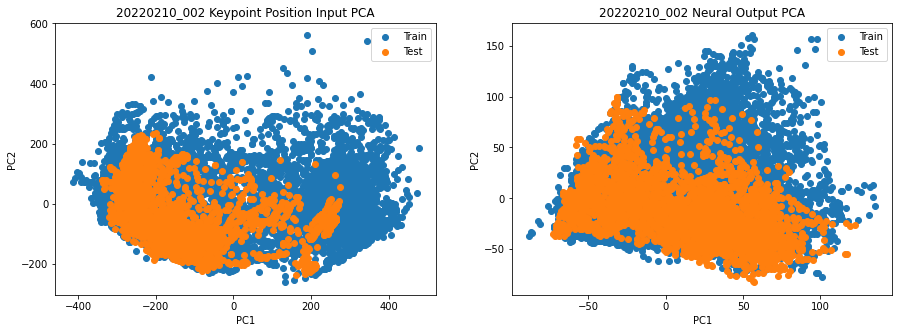



DATE: 20220224 
Neural File Time Duration: 600.0095 
Neural File Spikes Shape: (18001, 108) 
Jarvis Preds Shape: (18000, 69) 
Jarvis Preds num nans: 0

Keypoint Position Variance PC1: 0.6498, Keypoint Position Variance PC2: 0.1839, Variance PC1+PC2: 0.8337000000000001
Neural Variance PC1: 0.2135, Neural Variance PC2: 0.1311, Variance PC1+PC2: 0.3446


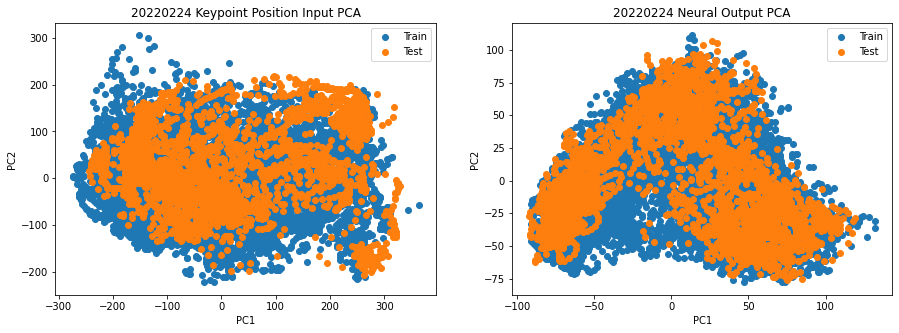



DATE: 20210712 
Neural File Time Duration: 1200.0040000000001 
Neural File Spikes Shape: (36001, 142) 
Jarvis Preds Shape: (36000, 69) 
Jarvis Preds num nans: 0

Keypoint Position Variance PC1: 0.4848, Keypoint Position Variance PC2: 0.3365, Variance PC1+PC2: 0.8213
Neural Variance PC1: 0.1866, Neural Variance PC2: 0.1195, Variance PC1+PC2: 0.3061


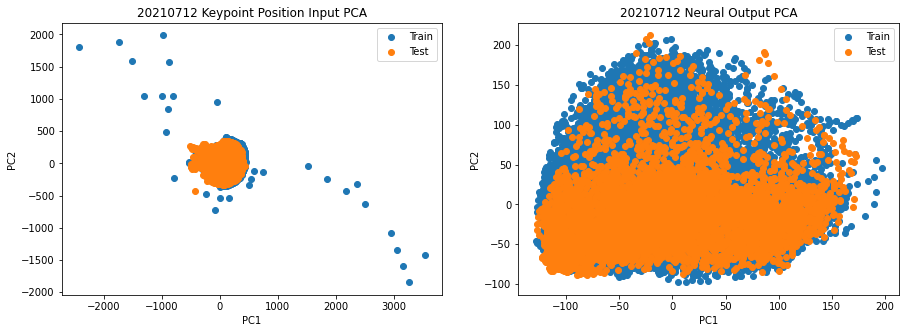



DATE: 20211105 
Neural File Time Duration: 1200.0040000000001 
Neural File Spikes Shape: (36001, 113) 
Jarvis Preds Shape: (36000, 69) 
Jarvis Preds num nans: 0

Keypoint Position Variance PC1: 0.4859, Keypoint Position Variance PC2: 0.2486, Variance PC1+PC2: 0.7344999999999999
Neural Variance PC1: 0.2164, Neural Variance PC2: 0.133, Variance PC1+PC2: 0.34940000000000004


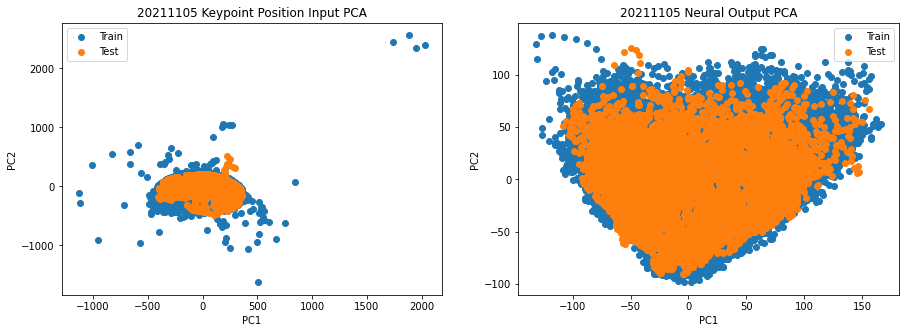

In [55]:
# Visualize data using PCA
for i, (binnedsortedspikes, jarvispred) in enumerate(zip(neuraldata_list_nonans, jarvispreds_list_nonans)):
    date = date_list_nonans[i]
    num_jarv_nans = np.sum(np.isnan(jarvispred))
    print('DATE: {} \nNeural File Time Duration: {} \nNeural File Spikes Shape: {} \nJarvis Preds Shape: {} \nJarvis Preds num nans: {}\n'\
          .format(date, binnedsortedspikes.get_meta()['duration'], binnedsortedspikes.spike_counts.shape, jarvispred.shape, num_jarv_nans))

    # PCA - visualization
    num_instances = jarvispred.shape[0]
    train_split = int(num_instances*.8)

    fig, ax = plt.subplots(nrows = 1, ncols = 2)

    pca_glove = PCA(n_components=2)
    pca_neural = PCA(n_components=2)

    pca_glove_features = pca_glove.fit_transform(jarvispred)
    pca_neural_features = pca_neural.fit_transform(binnedsortedspikes.spike_counts)
    
    pca_glove_var = pca_glove.explained_variance_ratio_
    pca_neural_var = pca_neural.explained_variance_ratio_

    pca1_glove_var, pca2_glove_var = round(pca_glove_var[0],4), round(pca_glove_var[1],4)
    pca1_neural_var, pca2_neural_var = round(pca_neural_var[0],4), round(pca_neural_var[1],4)

    print('Keypoint Position Variance PC1: {}, Keypoint Position Variance PC2: {}, Variance PC1+PC2: {}'.format(pca1_glove_var, pca2_glove_var, pca1_glove_var+pca2_glove_var))
    print('Neural Variance PC1: {}, Neural Variance PC2: {}, Variance PC1+PC2: {}'.format(pca1_neural_var, pca2_neural_var, pca1_neural_var+pca2_neural_var))
    
    fig.set_size_inches(15, 5)
    ax[0].scatter(pca_glove_features[:train_split,0], pca_glove_features[:train_split,1], label='Train')
    ax[0].scatter(pca_glove_features[train_split:,0], pca_glove_features[train_split:,1], label='Test')

    ax[1].scatter(pca_neural_features[:train_split,0], pca_neural_features[:train_split,1],label='Train')
    ax[1].scatter(pca_neural_features[train_split:,0], pca_neural_features[train_split:,1], label='Test')

    ax[0].set_xlabel('PC1')
    ax[0].set_ylabel('PC2')
    ax[1].set_xlabel('PC1')
    ax[1].set_ylabel('PC2')

    ax[0].set_title('{} Keypoint Position Input PCA'.format(date))
    ax[1].set_title('{} Neural Output PCA'.format(date))

    ax[0].legend()
    ax[1].legend()

    plt.show()

    print('\n')

# Build Dataset

In [32]:
index_dict = {'20220203': 0, '20220210_001': 1, '20220210_002': 2, '20220224': 3, '20210712': 4, '20211105': 5}

In [38]:
x=np.random.rand(3,2)
np.mean(x, axis =0)

array([0.57929051, 0.51100886])

In [33]:
class CustomDataset(Dataset):
    def __init__(self, date, center_inputs = False, normalize_inputs = False, smooth_inputs = False, shuffle = False, convert_keypoints_to_angles = False, velocity = False):
        self.date = date
        self.inputs = jarvispreds_list_nonans[index_dict[date]]
        self.input_dim = self.inputs.shape[-1]
        #remove last instance, as neural data has 1 too many instances after binning/smoothing
        neuraldata = neuraldata_list_nonans[index_dict[date]].spike_counts[:-1,:]
        self.num_neural_units = neuraldata.shape[1]
        self.neuraloutputs = neuraldata
        self.sample_nums = np.arange(len(self.inputs))

        self.center_inputs = center_inputs
        self.normalize_inputs = normalize_inputs
        self.smooth_inputs = smooth_inputs
        self.shuffle = shuffle
        self.convert_keypoints_to_angles = convert_keypoints_to_angles
        self.velocity = velocity

        def center(inp):
            #center by subtracting palm coordinates
            palm_x, palm_y, palm_z = inp[:,60], inp[:,61], inp[:,62]
            centered_inputs = []
            i = 0
            while i <= 66:
                feature_x, feature_y, feature_z = inp[:, i], inp[:, i+1], inp[:, i+2]
                feature_x_centered, feature_y_centered, feature_z_centered = feature_x-palm_x, feature_y-palm_y, feature_z-palm_z
                centered_inputs.append(feature_x_centered)
                centered_inputs.append(feature_y_centered)
                centered_inputs.append(feature_z_centered)
                i += 3
            
            centered_inputs_arr = np.asarray(centered_inputs).T
            return(centered_inputs_arr)

        def normalize(inp):
            mean = np.mean(inp, axis = 0)
            var = np.var(inp, axis = 0)
            normalized_inp = (inp-mean)/var
            return(normalized_inp)
        
        def smooth(input, bin_size = 1/30, kernel_type='gaussian', kernel_SD=1/15):
            inp = input.T.tolist()
            smoothed = [] #create new list for smoothed spike counts
            kernel_hl = 3 * int( kernel_SD / bin_size ) #this will be 3x2=6
            normalDistribution = stats.norm(0, kernel_SD)
            x = np.arange(-kernel_hl*bin_size, (kernel_hl+1)*bin_size, bin_size) #create array that goes from -kernel_hl*bin_size to kernel_hl*bin_size, distance between each data points is bin_size
            kernel = normalDistribution.pdf(x) 
            if kernel_type == 'gaussian':
                pass
            elif kernel_type == 'half_gaussian':
                for i in range(0, int(kernel_hl)):
                    kernel[i] = 0
            n_sample = np.size(inp[0])
            nm = np.convolve(kernel, np.ones((n_sample))).T[int(kernel_hl):n_sample + int(kernel_hl)] 
            for each in inp:
                temp1 = np.convolve(kernel,each)
                temp2 = temp1[int(kernel_hl):n_sample + int(kernel_hl)]/nm
                smoothed.append(temp2)
            smoothed_array = np.asarray(smoothed).T
            return(smoothed_array)

        def shuffle_data(inputs, targets, samp_nums):
            assert len(inputs) == len(targets)
            p = np.random.permutation(len(inputs))
            return(inputs[p], targets[p], samp_nums[p])

        if self.center_inputs == True:
            self.inputs = center(self.inputs)
        if self.smooth_inputs == True:
            self.inputs = smooth(self.inputs)
        if self.convert_keypoints_to_angles == True:
            self.input_dim = 15
            self.inputs = joint_angles.get_joint_angles(self.inputs)
        if self.velocity == True:
            self.inputs = joint_angles.get_joint_velocities(self.inputs)
        if self.normalize_inputs == True:
            self.inputs = normalize(self.inputs)

        if shuffle == True:
            self.inputs, self.neuraloutputs, self.sample_nums = \
              shuffle_data(self.inputs, self.neuraloutputs, self.sample_nums)

    def __len__(self):
        assert len(self.inputs) == len(self.neuraloutputs)
        return len(self.inputs)

    def __getitem__(self, idx):
        input = torch.from_numpy(self.inputs[idx])
        neuraloutput = torch.from_numpy(self.neuraloutputs[idx])
        sample_num = self.sample_nums[idx]
        #input is transposed for convenience - better for Conv1D
        return input.float().t(), neuraloutput.float(), sample_num

In [36]:
dataset20220203 = CustomDataset('20220203', center_inputs = True, smooth_inputs = True, shuffle = True)
dataset20220210_001 = CustomDataset('20220210_001', center_inputs = True, smooth_inputs = True, shuffle = True)
dataset20220210_002 = CustomDataset('20220210_002', center_inputs = True, smooth_inputs = True, shuffle = True)
dataset20220224 = CustomDataset('20220224', center_inputs = True, smooth_inputs = True, shuffle = True)
dataset20210712 = CustomDataset('20210712', center_inputs = True, smooth_inputs = True, shuffle = True)
dataset20211105 = CustomDataset('20211105', center_inputs = True, smooth_inputs = True, shuffle = True)

dataset20220203_unsmoothed = CustomDataset('20220203', center_inputs = True, shuffle = True)
dataset20220210_001_unsmoothed = CustomDataset('20220210_001', center_inputs = True, shuffle = True)
dataset20220210_002_unsmoothed = CustomDataset('20220210_002', center_inputs = True, shuffle = True)
dataset20220224_unsmoothed = CustomDataset('20220224', center_inputs = True, shuffle = True)
dataset20210712_unsmoothed = CustomDataset('20210712', center_inputs = True, shuffle = True)
dataset20211105_unsmoothed = CustomDataset('20211105', center_inputs = True, shuffle = True)

dataset20220203_uncentered_unsmoothed = CustomDataset('20220203', shuffle = True)
dataset20220210_001_uncentered_unsmoothed = CustomDataset('20220210_001', shuffle = True)
dataset20220210_002_uncentered_unsmoothed = CustomDataset('20220210_002', shuffle = True)
dataset20220224_uncentered_unsmoothed = CustomDataset('20220224', shuffle = True)
dataset20210712_uncentered_unsmoothed = CustomDataset('20210712', shuffle = True)
dataset20211105_uncentered_unsmoothed = CustomDataset('20211105', shuffle = True)

dataset_list = [dataset20220203,dataset20220210_001,dataset20220210_002,dataset20220224,dataset20210712,dataset20211105]
dataset_list_unsmoothed = [dataset20220203_unsmoothed,dataset20220210_001_unsmoothed,dataset20220210_002_unsmoothed,dataset20220224_unsmoothed,dataset20210712_unsmoothed,dataset20211105_unsmoothed]
dataset_list_uncentered_unsmoothed = [dataset20220203_uncentered_unsmoothed,dataset20220210_001_uncentered_unsmoothed,dataset20220210_002_uncentered_unsmoothed,dataset20220224_uncentered_unsmoothed,dataset20210712_uncentered_unsmoothed,dataset20211105_uncentered_unsmoothed]

In [40]:
joints_dataset20220203 = CustomDataset('20220203', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, shuffle = True, normalize_inputs = True)
joints_dataset20220210_001 = CustomDataset('20220210_001', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, shuffle = True, normalize_inputs = True)
joints_dataset20220210_002 = CustomDataset('20220210_002', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, shuffle = True, normalize_inputs = True)
joints_dataset20220224 = CustomDataset('20220224', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, shuffle = True, normalize_inputs = True)
joints_dataset20210712 = CustomDataset('20210712', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, shuffle = True, normalize_inputs = True)
joints_dataset20211105 = CustomDataset('20211105', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, shuffle = True, normalize_inputs = True)

joint_velocities_dataset20220203 = CustomDataset('20220203', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, velocity = True, shuffle = True, normalize_inputs = True)
joint_velocities_dataset20220210_001 = CustomDataset('20220210_001', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, velocity = True, shuffle = True, normalize_inputs = True)
joint_velocities_dataset20220210_002 = CustomDataset('20220210_002', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, velocity = True, shuffle = True, normalize_inputs = True)
joint_velocities_dataset20220224 = CustomDataset('20220224', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, velocity = True, shuffle = True, normalize_inputs = True)
joint_velocities_dataset20210712 = CustomDataset('20210712', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, velocity = True, shuffle = True, normalize_inputs = True)
joint_velocities_dataset20211105 = CustomDataset('20211105', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, velocity = True, shuffle = True, normalize_inputs = True)

joints_dataset_list = [joints_dataset20220203,joints_dataset20220210_001,joints_dataset20220210_002,joints_dataset20220224]
joint_velocities_dataset_list = [joint_velocities_dataset20220203,joint_velocities_dataset20220210_001,joint_velocities_dataset20220210_002,joint_velocities_dataset20220224]

In [41]:
for dataset in dataset_list:
  print(('{} \nnum instances: {} \nJarvis input shape: {} \nNeural Spikes shape: {}\n').\
        format(dataset.date, len(dataset), dataset[0][0].shape, dataset[0][1].shape))

20220203 
num instances: 18000 
Jarvis input shape: torch.Size([69]) 
Neural Spikes shape: torch.Size([44])

20220210_001 
num instances: 18000 
Jarvis input shape: torch.Size([69]) 
Neural Spikes shape: torch.Size([62])

20220210_002 
num instances: 18000 
Jarvis input shape: torch.Size([69]) 
Neural Spikes shape: torch.Size([62])

20220224 
num instances: 18000 
Jarvis input shape: torch.Size([69]) 
Neural Spikes shape: torch.Size([108])

20210712 
num instances: 36000 
Jarvis input shape: torch.Size([69]) 
Neural Spikes shape: torch.Size([142])

20211105 
num instances: 36000 
Jarvis input shape: torch.Size([69]) 
Neural Spikes shape: torch.Size([113])



In [42]:
for dataset in joints_dataset_list:
  print(('{} \nnum instances: {} \nJoint input shape: {} \nNeural Spikes shape: {}\n').\
        format(dataset.date, len(dataset), dataset[0][0].shape, dataset[0][1].shape))

20220203 
num instances: 18000 
Joint input shape: torch.Size([15]) 
Neural Spikes shape: torch.Size([44])

20220210_001 
num instances: 18000 
Joint input shape: torch.Size([15]) 
Neural Spikes shape: torch.Size([62])

20220210_002 
num instances: 18000 
Joint input shape: torch.Size([15]) 
Neural Spikes shape: torch.Size([62])

20220224 
num instances: 18000 
Joint input shape: torch.Size([15]) 
Neural Spikes shape: torch.Size([108])



In [43]:
torch.manual_seed(1)

train_loader_uncentered_unsmoothed_list = []
test_loader_uncentered_unsmoothed_list = []
toy_loader_uncentered_unsmoothed_list = []
train_loader_unsmoothed_list = []
test_loader_unsmoothed_list = []
toy_loader_unsmoothed_list = []
train_loader_list = []
test_loader_list = []
toy_loader_list = []
train_joints_loader_list = []
test_joints_loader_list = []
toy_joints_loader_list = []
train_joint_velocities_loader_list = []
test_joint_velocities_loader_list = []
toy_joint_velocities_loader_list = []

# 60/20/20 split for each session
for i, (dataset, dataset_unsmoothed, dataset_uncentered_unsmoothed, joints_dataset, joint_velocities_dataset) in \
 enumerate(zip(dataset_list, dataset_list_unsmoothed, dataset_list_uncentered_unsmoothed, joints_dataset_list, joint_velocities_dataset_list)):
    num_instances = len(dataset)
    train_split = int(num_instances*.8)

    train_dataset = Subset(dataset, np.arange(num_instances)[:train_split])
    test_dataset = Subset(dataset, np.arange(num_instances)[train_split:])
    # this is used to make sure the network can achieve zero loss on a single instance
    toy_dataset = Subset(dataset, np.arange(num_instances)[:4])

    train_dataset_unsmoothed = Subset(dataset_unsmoothed, np.arange(num_instances)[:train_split])
    test_dataset_unsmoothed = Subset(dataset_unsmoothed, np.arange(num_instances)[train_split:])
    # this is used to make sure the network can achieve zero loss on a single instance
    toy_dataset_unsmoothed = Subset(dataset_unsmoothed, np.arange(num_instances)[:4])

    train_dataset_uncentered_unsmoothed = Subset(dataset_uncentered_unsmoothed, np.arange(num_instances)[:train_split])
    test_dataset_uncentered_unsmoothed = Subset(dataset_uncentered_unsmoothed, np.arange(num_instances)[train_split:])
    # this is used to make sure the network can achieve zero loss on a single instance
    toy_dataset_uncentered_unsmoothed = Subset(dataset_uncentered_unsmoothed, np.arange(num_instances)[:4])

    train_joints_dataset = Subset(joints_dataset, np.arange(num_instances)[:train_split])
    test_joints_dataset = Subset(joints_dataset, np.arange(num_instances)[train_split:])
    # this is used to make sure the network can achieve zero loss on a single instance
    toy_joints_dataset = Subset(joints_dataset, np.arange(num_instances)[:4])

    train_joint_velocities_dataset = Subset(joint_velocities_dataset, np.arange(num_instances)[:train_split])
    test_joint_velocities_dataset = Subset(joint_velocities_dataset, np.arange(num_instances)[train_split:])
    # this is used to make sure the network can achieve zero loss on a single instance
    toy_joint_velocities_dataset = Subset(joint_velocities_dataset, np.arange(num_instances)[:4])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, pin_memory=True, sampler=None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, pin_memory=True)
    toy_loader = torch.utils.data.DataLoader(toy_dataset, batch_size=4, pin_memory=True)
    train_loader_unsmoothed = torch.utils.data.DataLoader(train_dataset_unsmoothed, batch_size=32, pin_memory=True, sampler=None)
    test_loader_unsmoothed = torch.utils.data.DataLoader(test_dataset_unsmoothed, batch_size=32, pin_memory=True)
    toy_loader_unsmoothed = torch.utils.data.DataLoader(toy_dataset_unsmoothed, batch_size=4, pin_memory=True)
    train_loader_uncentered_unsmoothed = torch.utils.data.DataLoader(train_dataset_uncentered_unsmoothed, batch_size=32, pin_memory=True, sampler=None)
    test_loader_uncentered_unsmoothed = torch.utils.data.DataLoader(test_dataset_uncentered_unsmoothed, batch_size=32, pin_memory=True)
    toy_loader_uncentered_unsmoothed = torch.utils.data.DataLoader(toy_dataset_uncentered_unsmoothed, batch_size=4, pin_memory=True)
    train_joints_loader = torch.utils.data.DataLoader(train_joints_dataset, batch_size=32, pin_memory=True, sampler=None)
    test_joints_loader = torch.utils.data.DataLoader(test_joints_dataset, batch_size=32, pin_memory=True)
    toy_joints_loader = torch.utils.data.DataLoader(toy_joints_dataset, batch_size=4, pin_memory=True)
    train_joint_velocities_loader = torch.utils.data.DataLoader(train_joint_velocities_dataset, batch_size=32, pin_memory=True, sampler=None)
    test_joint_velocities_loader = torch.utils.data.DataLoader(test_joint_velocities_dataset, batch_size=32, pin_memory=True)
    toy_joint_velocities_loader = torch.utils.data.DataLoader(toy_joint_velocities_dataset, batch_size=4, pin_memory=True)

    train_loader_list.append(train_loader)
    test_loader_list.append(test_loader)
    toy_loader_list.append(toy_loader)
    train_loader_unsmoothed_list.append(train_loader_unsmoothed)
    test_loader_unsmoothed_list.append(test_loader_unsmoothed)
    toy_loader_unsmoothed_list.append(toy_loader_unsmoothed)
    train_loader_uncentered_unsmoothed_list.append(train_loader_uncentered_unsmoothed)
    test_loader_uncentered_unsmoothed_list.append(test_loader_uncentered_unsmoothed)
    toy_loader_uncentered_unsmoothed_list.append(toy_loader_uncentered_unsmoothed)
    train_joints_loader_list.append(train_joints_loader)
    test_joints_loader_list.append(test_joints_loader)
    toy_joints_loader_list.append(toy_joints_loader)
    train_joint_velocities_loader_list.append(train_joint_velocities_loader)
    test_joint_velocities_loader_list.append(test_joint_velocities_loader)
    toy_joint_velocities_loader_list.append(toy_joint_velocities_loader)

    print('Date: {}'.format(dataset.date))
    print('Total dataset size: {}'.format(len(dataset)))
    print('Number of train instances: {}, Number of test instances: {}'\
          .format(len(train_dataset), len(test_dataset)))

Date: 20220203
Total dataset size: 18000
Number of train instances: 14400, Number of test instances: 3600
Date: 20220210_001
Total dataset size: 18000
Number of train instances: 14400, Number of test instances: 3600
Date: 20220210_002
Total dataset size: 18000
Number of train instances: 14400, Number of test instances: 3600
Date: 20220224
Total dataset size: 18000
Number of train instances: 14400, Number of test instances: 3600


# Building and Training Model

In [ ]:
class FCNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, hidden_layer_dim, add_relu = False):
        super(FCNet, self).__init__()
        self.net = nn.ModuleList()
        assert num_layers >= 2
        self.num_layers = num_layers
        self.hidden_layer_dim = hidden_layer_dim

        if type(hidden_layer_dim == int):
            # input layer
            self.net.append(nn.Linear(input_dim, hidden_layer_dim))
            self.net.append(nn.ReLU())
            # hidden layers
            for i in range(num_layers-2):
                self.net.append(nn.Linear(hidden_layer_dim, hidden_layer_dim))
                self.net.append(nn.ReLU())
            # output layer
            self.net.append(nn.Linear(hidden_layer_dim, output_dim))
            if add_relu == True:
                self.net.append(nn.ReLU())
        
        elif type(hidden_layer_dim == list):
            assert len(hidden_layer_dim) == num_layers-1

            self.net.append(nn.Linear(input_dim, hidden_layer_dim[0]))
            self.net.append(nn.ReLU())
            for i in range(len(hidden_layer_dim)-1):
                self.net.append(nn.Linear(hidden_layer_dim[i], hidden_layer_dim[i+1]))
                self.net.append(nn.ReLU())
            self.net.append(nn.Linear(hidden_layer_dim[-1], output_dim))
    
    def forward(self, x):
        for layer in self.net:
            x = layer(x)
        return(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train(loader, model, optimizer, criterion):
    model.train()
    batch_losses = []

    for i, (input, target, sample_num) in enumerate(loader):
        optimizer.zero_grad() #clear gradient
        input = input.to(device, dtype=torch.float)
        target = target.to(device, dtype=torch.float)
        
        pred = model(input)
        # print(pred.shape, target.shape)
        loss = criterion(pred, target)  # calculate loss
        mean_batch_loss = loss.item()
        batch_losses.append(mean_batch_loss)

        loss.backward()  # one backward pass
        optimizer.step()  # update the parameters

    avg_loss_epoch = sum(batch_losses)/len(batch_losses)
    return(avg_loss_epoch)

def test(loader, model, optimizer, criterion):
    model.eval()
    batch_losses = []

    with torch.no_grad():
        for i, (input, target, sample_num) in enumerate(loader):
            input = input.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.float)
            pred = model(input)

            loss = criterion(pred, target)  
            mean_batch_loss = loss.item()
            batch_losses.append(mean_batch_loss)

    avg_loss_epoch = sum(batch_losses)/len(batch_losses)
    return(avg_loss_epoch)

def get_instance_losses(loader, model, criterion = torch.nn.MSELoss(reduction='none')):
    model.eval()
    inputs = []
    targets = []
    preds = []
    sample_nums = []
    losses = []

    with torch.no_grad():
        for i, (input, target, sample_num) in enumerate(loader):
            input = input.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.float)

            pred = model(input)
            all_losses_batch = criterion(pred, target)  # calculate loss
            all_losses_batch = all_losses_batch.detach().cpu().data.numpy()
            
            inputs.append(input.cpu().data.numpy())
            targets.append(target.cpu().data.numpy())
            sample_nums.append(sample_num)
            preds.append(pred)
            losses.append(all_losses_batch)

    all_inputs = np.vstack(inputs)
    all_targets = np.vstack(targets)
    all_preds = np.vstack(preds)
    all_sample_nums = np.hstack(sample_nums)

    all_losses = np.vstack(losses)
    all_losses = np.mean(all_losses, axis = 1)
    all_data = [all_losses, all_inputs, all_targets, all_preds, all_sample_nums]
    return(all_data)

# Overfitting to single batch, 4 instances

Epoch: 000, LR: 0.010000, Train Loss: 9492.8398438
Epoch: 050, LR: 0.010000, Train Loss: 191.5646362
Epoch: 100, LR: 0.010000, Train Loss: 152.5860596
Epoch: 150, LR: 0.010000, Train Loss: 141.2228088
Epoch: 200, LR: 0.010000, Train Loss: 133.8192596
Epoch: 250, LR: 0.010000, Train Loss: 129.7049408
Epoch: 300, LR: 0.010000, Train Loss: 191.9594116


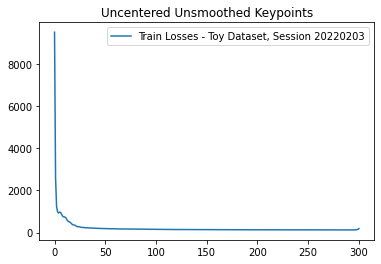

Epoch: 000, LR: 0.010000, Train Loss: 14972.7050781
Epoch: 050, LR: 0.010000, Train Loss: 542.6109009
Epoch: 100, LR: 0.010000, Train Loss: 530.6436768
Epoch: 150, LR: 0.010000, Train Loss: 518.3806763
Epoch: 200, LR: 0.010000, Train Loss: 506.1454163
Epoch: 250, LR: 0.010000, Train Loss: 494.0818176
Epoch: 300, LR: 0.010000, Train Loss: 482.2651062


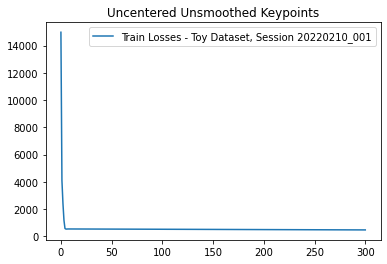

Epoch: 000, LR: 0.010000, Train Loss: 5179.3261719
Epoch: 050, LR: 0.010000, Train Loss: 120.4763794
Epoch: 100, LR: 0.010000, Train Loss: 111.2228165
Epoch: 150, LR: 0.010000, Train Loss: 110.9446793
Epoch: 200, LR: 0.010000, Train Loss: 110.6737213
Epoch: 250, LR: 0.010000, Train Loss: 110.3716049
Epoch: 300, LR: 0.010000, Train Loss: 110.0407257


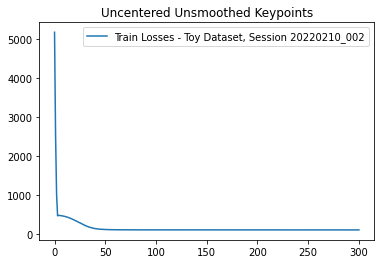

Epoch: 000, LR: 0.010000, Train Loss: 6852.2036133
Epoch: 050, LR: 0.010000, Train Loss: 292.6417847
Epoch: 100, LR: 0.010000, Train Loss: 284.3054199
Epoch: 150, LR: 0.010000, Train Loss: 275.9419250
Epoch: 200, LR: 0.010000, Train Loss: 267.7313843
Epoch: 250, LR: 0.010000, Train Loss: 259.7476807
Epoch: 300, LR: 0.010000, Train Loss: 252.0256958


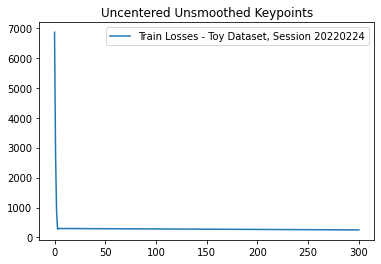

Epoch: 000, LR: 0.010000, Train Loss: 444.4699402
Epoch: 050, LR: 0.010000, Train Loss: 0.6500741
Epoch: 100, LR: 0.010000, Train Loss: 0.0034919
Epoch: 150, LR: 0.010000, Train Loss: 0.0000227
Epoch: 200, LR: 0.010000, Train Loss: 0.0000001
Epoch: 250, LR: 0.010000, Train Loss: 0.0000000
Epoch: 300, LR: 0.010000, Train Loss: 0.0000000


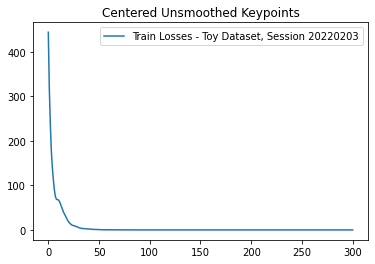

Epoch: 000, LR: 0.010000, Train Loss: 516.0017090
Epoch: 050, LR: 0.010000, Train Loss: 1.6535076
Epoch: 100, LR: 0.010000, Train Loss: 0.0064584
Epoch: 150, LR: 0.010000, Train Loss: 0.0000362
Epoch: 200, LR: 0.010000, Train Loss: 0.0000002
Epoch: 250, LR: 0.010000, Train Loss: 0.0000000
Epoch: 300, LR: 0.010000, Train Loss: 0.0000000


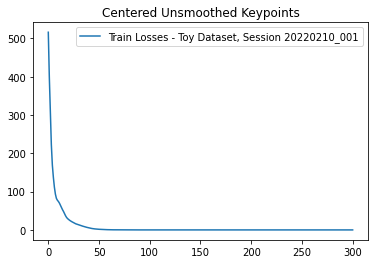

Epoch: 000, LR: 0.010000, Train Loss: 429.5056152
Epoch: 050, LR: 0.010000, Train Loss: 7.8045721
Epoch: 100, LR: 0.010000, Train Loss: 0.0945263
Epoch: 150, LR: 0.010000, Train Loss: 0.0004389
Epoch: 200, LR: 0.010000, Train Loss: 0.0000021
Epoch: 250, LR: 0.010000, Train Loss: 0.0000000
Epoch: 300, LR: 0.010000, Train Loss: 0.0000000


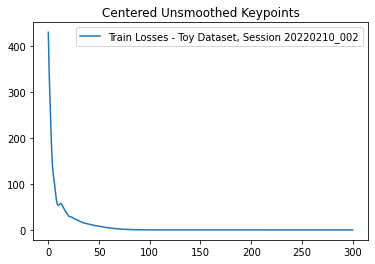

Epoch: 000, LR: 0.010000, Train Loss: 385.6515503
Epoch: 050, LR: 0.010000, Train Loss: 2.7759552
Epoch: 100, LR: 0.010000, Train Loss: 0.0113709
Epoch: 150, LR: 0.010000, Train Loss: 0.0000569
Epoch: 200, LR: 0.010000, Train Loss: 0.0000004
Epoch: 250, LR: 0.010000, Train Loss: 0.0000000
Epoch: 300, LR: 0.010000, Train Loss: 0.0000000


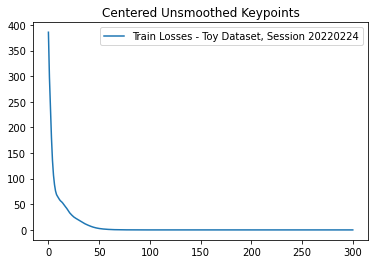

Epoch: 000, LR: 0.010000, Train Loss: 308.3032837
Epoch: 050, LR: 0.010000, Train Loss: 3.3576334
Epoch: 100, LR: 0.010000, Train Loss: 0.0145481
Epoch: 150, LR: 0.010000, Train Loss: 0.0000822
Epoch: 200, LR: 0.010000, Train Loss: 0.0000005
Epoch: 250, LR: 0.010000, Train Loss: 0.0000000
Epoch: 300, LR: 0.010000, Train Loss: 0.0000000


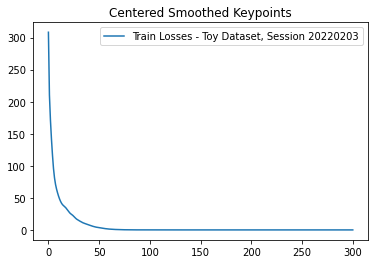

Epoch: 000, LR: 0.010000, Train Loss: 527.7197266
Epoch: 050, LR: 0.010000, Train Loss: 0.8798533
Epoch: 100, LR: 0.010000, Train Loss: 0.0047686
Epoch: 150, LR: 0.010000, Train Loss: 0.0000303
Epoch: 200, LR: 0.010000, Train Loss: 0.0000002
Epoch: 250, LR: 0.010000, Train Loss: 0.0000000
Epoch: 300, LR: 0.010000, Train Loss: 0.0000000


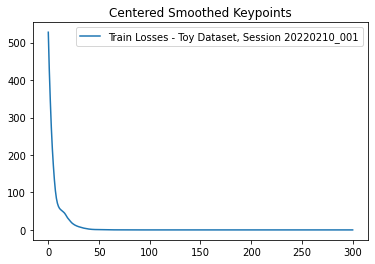

Epoch: 000, LR: 0.010000, Train Loss: 594.5755005
Epoch: 050, LR: 0.010000, Train Loss: 4.3612771
Epoch: 100, LR: 0.010000, Train Loss: 0.0179257
Epoch: 150, LR: 0.010000, Train Loss: 0.0001115
Epoch: 200, LR: 0.010000, Train Loss: 0.0000006
Epoch: 250, LR: 0.010000, Train Loss: 0.0000000
Epoch: 300, LR: 0.010000, Train Loss: 0.0000000


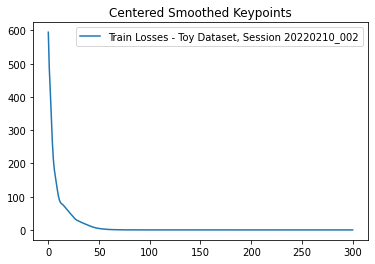

Epoch: 000, LR: 0.010000, Train Loss: 351.6092224
Epoch: 050, LR: 0.010000, Train Loss: 1.4593539
Epoch: 100, LR: 0.010000, Train Loss: 0.0066700
Epoch: 150, LR: 0.010000, Train Loss: 0.0000403
Epoch: 200, LR: 0.010000, Train Loss: 0.0154438
Epoch: 250, LR: 0.010000, Train Loss: 0.0000094
Epoch: 300, LR: 0.010000, Train Loss: 0.0000001


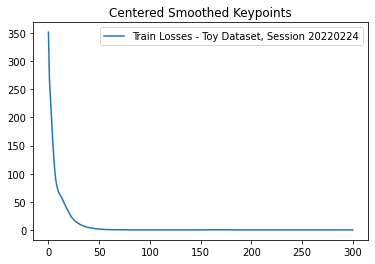

Epoch: 000, LR: 0.010000, Train Loss: 1909.8284912
Epoch: 050, LR: 0.010000, Train Loss: 107.7744598
Epoch: 100, LR: 0.010000, Train Loss: 70.5257034
Epoch: 150, LR: 0.010000, Train Loss: 46.2125473
Epoch: 200, LR: 0.010000, Train Loss: 33.4871864
Epoch: 250, LR: 0.010000, Train Loss: 17.6958923
Epoch: 300, LR: 0.010000, Train Loss: 6.7838078


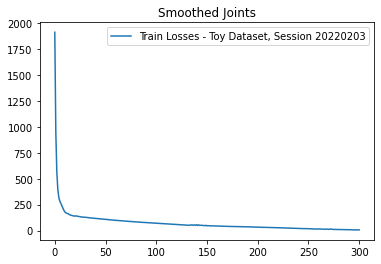

Epoch: 000, LR: 0.010000, Train Loss: 2459.3886719
Epoch: 050, LR: 0.010000, Train Loss: 113.7707520
Epoch: 100, LR: 0.010000, Train Loss: 76.9949493
Epoch: 150, LR: 0.010000, Train Loss: 36.3284836
Epoch: 200, LR: 0.010000, Train Loss: 18.9798241
Epoch: 250, LR: 0.010000, Train Loss: 14.0295343
Epoch: 300, LR: 0.010000, Train Loss: 11.2008610


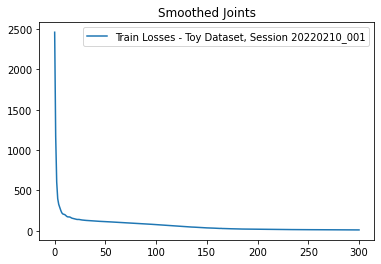

Epoch: 000, LR: 0.010000, Train Loss: 1290.2889404
Epoch: 050, LR: 0.010000, Train Loss: 131.0320892
Epoch: 100, LR: 0.010000, Train Loss: 90.9325104
Epoch: 150, LR: 0.010000, Train Loss: 63.1758347
Epoch: 200, LR: 0.010000, Train Loss: 44.8341713
Epoch: 250, LR: 0.010000, Train Loss: 28.2499027
Epoch: 300, LR: 0.010000, Train Loss: 18.5804501


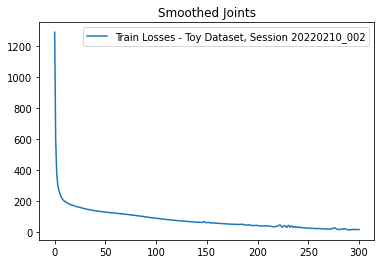

Epoch: 000, LR: 0.010000, Train Loss: 1277.5640869
Epoch: 050, LR: 0.010000, Train Loss: 67.1151047
Epoch: 100, LR: 0.010000, Train Loss: 53.0273018
Epoch: 150, LR: 0.010000, Train Loss: 33.4797630
Epoch: 200, LR: 0.010000, Train Loss: 17.9887638
Epoch: 250, LR: 0.010000, Train Loss: 10.7904015
Epoch: 300, LR: 0.010000, Train Loss: 4.3543591


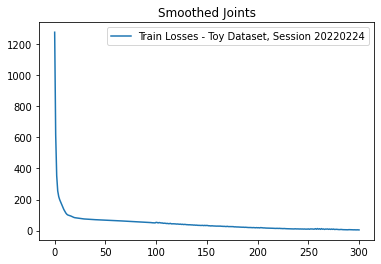

Epoch: 000, LR: 0.010000, Train Loss: 2611.3063965
Epoch: 050, LR: 0.010000, Train Loss: 0.9096295
Epoch: 100, LR: 0.010000, Train Loss: 0.0048969
Epoch: 150, LR: 0.010000, Train Loss: 0.0000348
Epoch: 200, LR: 0.010000, Train Loss: 0.0000002
Epoch: 250, LR: 0.010000, Train Loss: 0.0000000
Epoch: 300, LR: 0.010000, Train Loss: 0.0000000


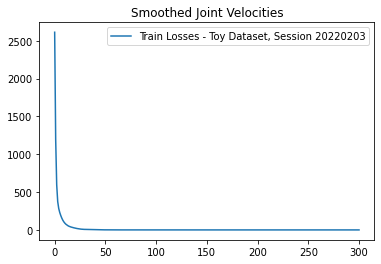

Epoch: 000, LR: 0.010000, Train Loss: 6202.5795898
Epoch: 050, LR: 0.010000, Train Loss: 3.9427342
Epoch: 100, LR: 0.010000, Train Loss: 0.0186585
Epoch: 150, LR: 0.010000, Train Loss: 0.0000857
Epoch: 200, LR: 0.010000, Train Loss: 0.0000005
Epoch: 250, LR: 0.010000, Train Loss: 0.0000000
Epoch: 300, LR: 0.010000, Train Loss: 0.0000000


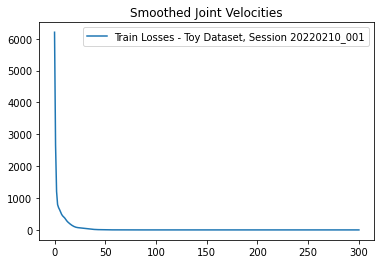

Epoch: 000, LR: 0.010000, Train Loss: 3641.2812500
Epoch: 050, LR: 0.010000, Train Loss: 4.5808954
Epoch: 100, LR: 0.010000, Train Loss: 0.0194541
Epoch: 150, LR: 0.010000, Train Loss: 0.0001168
Epoch: 200, LR: 0.010000, Train Loss: 0.0000006
Epoch: 250, LR: 0.010000, Train Loss: 0.0001098
Epoch: 300, LR: 0.010000, Train Loss: 0.0000237


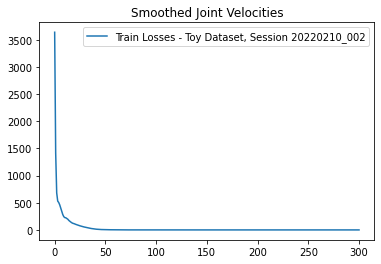

Epoch: 000, LR: 0.010000, Train Loss: 1071.0343018
Epoch: 050, LR: 0.010000, Train Loss: 1.2467140
Epoch: 100, LR: 0.010000, Train Loss: 0.0068834
Epoch: 150, LR: 0.010000, Train Loss: 0.0000374
Epoch: 200, LR: 0.010000, Train Loss: 0.0000002
Epoch: 250, LR: 0.010000, Train Loss: 0.0000000
Epoch: 300, LR: 0.010000, Train Loss: 0.0000000


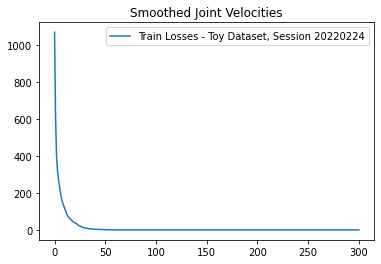

In [ ]:
toy_list_names = ['Uncentered Unsmoothed Keypoints', 'Centered Unsmoothed Keypoints', 'Centered Smoothed Keypoints', 'Smoothed Joints', 'Smoothed Joint Velocities']
toy_list = [toy_loader_uncentered_unsmoothed_list,toy_loader_unsmoothed_list,toy_loader_list,toy_joints_loader_list,toy_joint_velocities_loader_list,]

for name, lst in zip(toy_list_names, toy_list):
    for i in range(len(lst)):
        if (name == 'Smoothed Joints') or (name == 'Smoothed Joint Velocities'):
            #def __init__(self, input_dim, output_dim, num_layers, hidden_layer_dim)
            model = FCNet(input_dim = 15, output_dim=dataset_list[i].num_neural_units, num_layers = 2, hidden_layer_dim = 35).to(device)
        else:
            model = FCNet(input_dim = 69, output_dim=dataset_list[i].num_neural_units, num_layers = 2, hidden_layer_dim = 35).to(device)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5, min_lr=0.00001)   

        train_losses = []

        for epoch in range(301):
            # torch.cuda.empty_cache()
            lr = scheduler.optimizer.param_groups[0]['lr']
            train_loss = train(lst[i], model, optimizer, criterion)
            if epoch % 50 ==0:
                print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}'\
                      .format(epoch, lr, train_loss))

            train_losses.append(train_loss)

        instance_data = get_instance_losses(lst[i], model)
        target = pred = instance_data[2]
        pred = instance_data[3]

        plt.plot(train_losses)
        plt.title(name)
        plt.legend(['Train Losses - Toy Dataset, Session {}'.format(dataset_list[i].date)])
        plt.show()

In [ ]:
def get_pr2(real_data, predictions, EPS = 0.000001):
    predictions = predictions+EPS
    m = np.mean(real_data, axis = 0)
    division1 = (real_data/predictions)+EPS
    division2 = (real_data/m)+EPS
    sum1 = np.sum(real_data*np.log( division1 ) - ( real_data - predictions ) )
    sum2 = np.sum( real_data*np.log( division2 ) - ( real_data - m ) )
    if ( sum2 == 0 ):
        sum2 = EPS
    pR2 = 1 - sum1/sum2
    return(pR2)

# Training on Full Dataset: Smoothed Joint Velocities

Date: 20220203
Model Number: 0
Num Layers: 2, Hidden Layer Dimensionality: 35, Total Parameters: 2144
Epoch: 000, LR: 0.010000, Train Loss: 247.1274001, Test Loss: 208.6295903
Epoch: 050, LR: 0.003430, Train Loss: 156.3925022, Test Loss: 153.5122170
Epoch: 100, LR: 0.000824, Train Loss: 147.3060988, Test Loss: 148.4611773
Epoch: 150, LR: 0.000068, Train Loss: 144.2437026, Test Loss: 147.2732959
Epoch: 200, LR: 0.000010, Train Loss: 143.8686726, Test Loss: 147.2500298
Epoch: 250, LR: 0.000010, Train Loss: 143.8324704, Test Loss: 147.2904282
Time to train model: 201.17522048950195


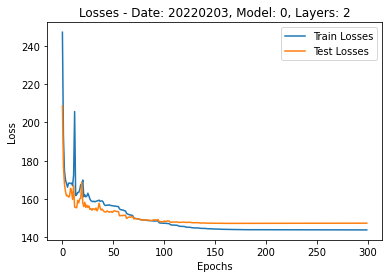

R2 Train: 0.15105323594252013, R2 Test: 0.11087004503337346
Model Number: 1
Num Layers: 3, Hidden Layer Dimensionality: 35, Total Parameters: 3404
Epoch: 000, LR: 0.010000, Train Loss: 235.0440426, Test Loss: 205.3444733
Epoch: 050, LR: 0.002401, Train Loss: 143.5383308, Test Loss: 145.9164024
Epoch: 100, LR: 0.000138, Train Loss: 139.2781539, Test Loss: 146.5156241
Epoch: 150, LR: 0.000010, Train Loss: 138.9950254, Test Loss: 147.1938624
Epoch: 200, LR: 0.000010, Train Loss: 138.9758844, Test Loss: 147.2828865
Epoch: 250, LR: 0.000010, Train Loss: 138.9552475, Test Loss: 147.3562540
Time to train model: 247.1404001712799


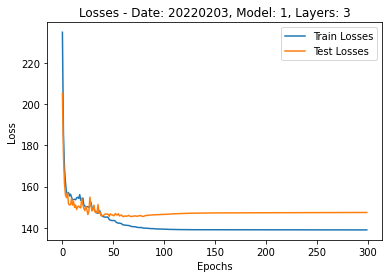

R2 Train: 0.1796000974924282, R2 Test: 0.10945514860194601
Model Number: 2
Num Layers: 4, Hidden Layer Dimensionality: 35, Total Parameters: 4664
Epoch: 000, LR: 0.010000, Train Loss: 228.8621946, Test Loss: 187.2487508
Epoch: 050, LR: 0.003430, Train Loss: 143.7676800, Test Loss: 145.3465025
Epoch: 100, LR: 0.000824, Train Loss: 138.0508127, Test Loss: 143.7907610
Epoch: 150, LR: 0.000033, Train Loss: 136.6896171, Test Loss: 145.0369396
Epoch: 200, LR: 0.000010, Train Loss: 136.6170387, Test Loss: 145.1100635
Epoch: 250, LR: 0.000010, Train Loss: 136.5952191, Test Loss: 145.1201128
Time to train model: 280.7380566596985


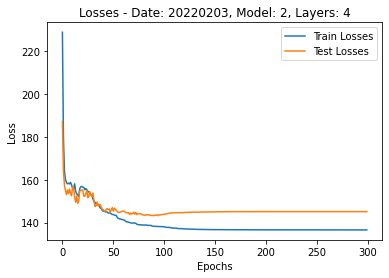

R2 Train: 0.1935115486798787, R2 Test: 0.12344453767602565
Date: 20220210_001
Model Number: 0
Num Layers: 2, Hidden Layer Dimensionality: 35, Total Parameters: 2792
Epoch: 000, LR: 0.010000, Train Loss: 296.1423619, Test Loss: 230.4402320
Epoch: 050, LR: 0.002401, Train Loss: 129.3869748, Test Loss: 127.6795049
Epoch: 100, LR: 0.000282, Train Loss: 125.4200203, Test Loss: 126.4109435
Epoch: 150, LR: 0.000016, Train Loss: 124.7021909, Test Loss: 126.2215582
Epoch: 200, LR: 0.000010, Train Loss: 124.6649927, Test Loss: 126.2378888
Epoch: 250, LR: 0.000010, Train Loss: 124.6518014, Test Loss: 126.2457679
Time to train model: 206.69045758247375


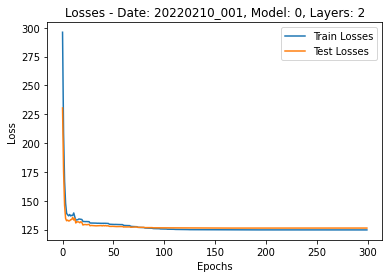

R2 Train: 0.043339621960674854, R2 Test: 0.015323529469464848
Model Number: 1
Num Layers: 3, Hidden Layer Dimensionality: 35, Total Parameters: 4052
Epoch: 000, LR: 0.010000, Train Loss: 265.8295908, Test Loss: 231.9704169
Epoch: 050, LR: 0.004900, Train Loss: 125.6926651, Test Loss: 124.4625764
Epoch: 100, LR: 0.000576, Train Loss: 122.0492621, Test Loss: 124.0735256
Epoch: 150, LR: 0.000033, Train Loss: 121.4405675, Test Loss: 124.3821718
Epoch: 200, LR: 0.000010, Train Loss: 121.4044941, Test Loss: 124.4160011
Epoch: 250, LR: 0.000010, Train Loss: 121.3972833, Test Loss: 124.4348785
Time to train model: 249.55814146995544


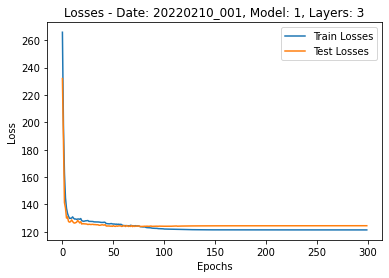

R2 Train: 0.06812803150180251, R2 Test: 0.02936025912832778
Model Number: 2
Num Layers: 4, Hidden Layer Dimensionality: 35, Total Parameters: 5312
Epoch: 000, LR: 0.010000, Train Loss: 219.0303992, Test Loss: 128.8967272
Epoch: 050, LR: 0.002401, Train Loss: 126.3780543, Test Loss: 125.4402743
Epoch: 100, LR: 0.000404, Train Loss: 124.0324920, Test Loss: 124.2588745
Epoch: 150, LR: 0.000033, Train Loss: 123.4824094, Test Loss: 124.2715458
Epoch: 200, LR: 0.000010, Train Loss: 123.4416461, Test Loss: 124.2789542
Epoch: 250, LR: 0.000010, Train Loss: 123.4290251, Test Loss: 124.2808694
Time to train model: 285.12826466560364


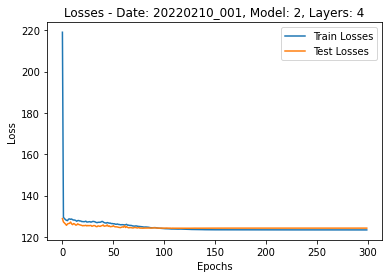

R2 Train: 0.05253238865425607, R2 Test: 0.030236796254044518
Date: 20220210_002
Model Number: 0
Num Layers: 2, Hidden Layer Dimensionality: 35, Total Parameters: 2792
Epoch: 000, LR: 0.010000, Train Loss: 308.3165162, Test Loss: 263.1927095
Epoch: 050, LR: 0.002401, Train Loss: 138.0048517, Test Loss: 140.1850881
Epoch: 100, LR: 0.000404, Train Loss: 132.4381919, Test Loss: 137.9495122
Epoch: 150, LR: 0.000047, Train Loss: 131.2857589, Test Loss: 137.6273935
Epoch: 200, LR: 0.000010, Train Loss: 131.1557142, Test Loss: 137.6104040
Epoch: 250, LR: 0.000010, Train Loss: 131.1359650, Test Loss: 137.6500642
Time to train model: 205.36404037475586


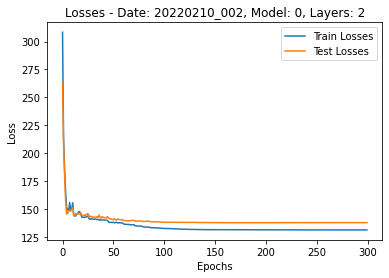

R2 Train: 0.08414751209081833, R2 Test: 0.039583507780258036
Model Number: 1
Num Layers: 3, Hidden Layer Dimensionality: 35, Total Parameters: 4052
Epoch: 000, LR: 0.010000, Train Loss: 286.4866952, Test Loss: 228.4315465
Epoch: 050, LR: 0.004900, Train Loss: 130.7146589, Test Loss: 133.3696281
Epoch: 100, LR: 0.001681, Train Loss: 127.7819827, Test Loss: 131.9202184
Epoch: 150, LR: 0.000138, Train Loss: 126.6343591, Test Loss: 131.4630335
Epoch: 200, LR: 0.000011, Train Loss: 126.4991365, Test Loss: 131.4472523
Epoch: 250, LR: 0.000010, Train Loss: 126.4937969, Test Loss: 131.4511307
Time to train model: 251.99831008911133


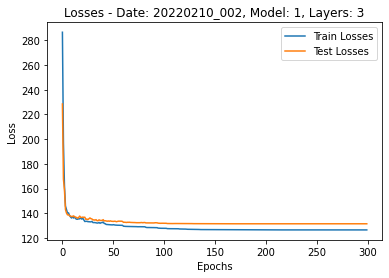

R2 Train: 0.11634353852717533, R2 Test: 0.08310169266565176
Model Number: 2
Num Layers: 4, Hidden Layer Dimensionality: 35, Total Parameters: 5312
Epoch: 000, LR: 0.010000, Train Loss: 278.1107758, Test Loss: 213.9472597
Epoch: 050, LR: 0.003430, Train Loss: 128.6906381, Test Loss: 133.7046596
Epoch: 100, LR: 0.000404, Train Loss: 125.4947798, Test Loss: 132.2894746
Epoch: 150, LR: 0.000023, Train Loss: 124.9260826, Test Loss: 132.5636593
Epoch: 200, LR: 0.000010, Train Loss: 124.8969504, Test Loss: 132.5802992
Epoch: 250, LR: 0.000010, Train Loss: 124.8875180, Test Loss: 132.5928853
Time to train model: 283.7609672546387


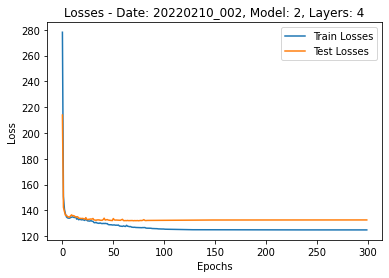

R2 Train: 0.1275969120509069, R2 Test: 0.0748935114266774
Date: 20220224
Model Number: 0
Num Layers: 2, Hidden Layer Dimensionality: 35, Total Parameters: 4448
Epoch: 000, LR: 0.010000, Train Loss: 235.9655798, Test Loss: 188.9868604
Epoch: 050, LR: 0.003430, Train Loss: 110.3681454, Test Loss: 111.2299439
Epoch: 100, LR: 0.000576, Train Loss: 107.8054613, Test Loss: 109.7400802
Epoch: 150, LR: 0.000068, Train Loss: 107.1351527, Test Loss: 109.5148536
Epoch: 200, LR: 0.000010, Train Loss: 107.0408565, Test Loss: 109.4774636
Epoch: 250, LR: 0.000010, Train Loss: 107.0321929, Test Loss: 109.4903126
Time to train model: 210.61645483970642


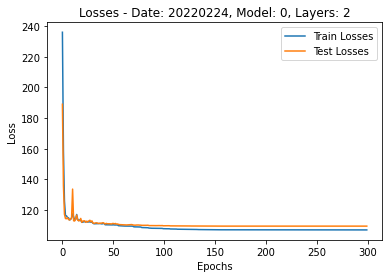

R2 Train: 0.029290090013504393, R2 Test: 0.011860419536967011
Model Number: 1
Num Layers: 3, Hidden Layer Dimensionality: 35, Total Parameters: 5708
Epoch: 000, LR: 0.010000, Train Loss: 216.5047471, Test Loss: 164.8827918
Epoch: 050, LR: 0.003430, Train Loss: 107.3404674, Test Loss: 109.9069269
Epoch: 100, LR: 0.000282, Train Loss: 104.8796073, Test Loss: 109.8434118
Epoch: 150, LR: 0.000011, Train Loss: 104.6351020, Test Loss: 109.8605322
Epoch: 200, LR: 0.000010, Train Loss: 104.6253411, Test Loss: 109.8665763
Epoch: 250, LR: 0.000010, Train Loss: 104.6173179, Test Loss: 109.8694432
Time to train model: 259.06908321380615


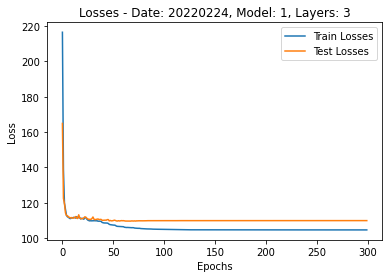

R2 Train: 0.051136013489214024, R2 Test: 0.008616778584216077
Model Number: 2
Num Layers: 4, Hidden Layer Dimensionality: 35, Total Parameters: 6968
Epoch: 000, LR: 0.010000, Train Loss: 208.3350588, Test Loss: 150.5522059
Epoch: 050, LR: 0.002401, Train Loss: 108.1819639, Test Loss: 110.0243289
Epoch: 100, LR: 0.000198, Train Loss: 106.7808725, Test Loss: 110.1316581
Epoch: 150, LR: 0.000011, Train Loss: 106.7033547, Test Loss: 110.2263500
Epoch: 200, LR: 0.000010, Train Loss: 106.6970418, Test Loss: 110.2317149
Epoch: 250, LR: 0.000010, Train Loss: 106.6907300, Test Loss: 110.2387712
Time to train model: 293.7559332847595


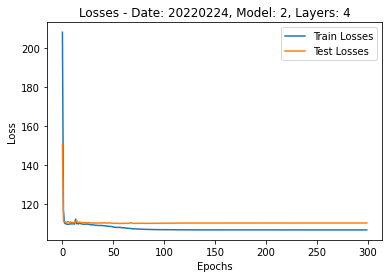

R2 Train: 0.03226018609194395, R2 Test: 0.005235783014874336


In [ ]:
all_instance_data = []

r2_train_list = []
r2_test_list = []
pr2_train_list = []
pr2_test_list = []

for j, (train_loader, test_loader) in enumerate(zip(train_joint_velocities_loader_list, test_joint_velocities_loader_list)):

    print('Date: {}'.format(dataset_list[j].date))
    models_list = [FCNet(input_dim = 15, output_dim=dataset_list[j].num_neural_units, num_layers = 2, hidden_layer_dim = 35).to(device),\
                   FCNet(input_dim = 15, output_dim=dataset_list[j].num_neural_units, num_layers = 3, hidden_layer_dim = 35).to(device),\
                   FCNet(input_dim = 15, output_dim=dataset_list[j].num_neural_units, num_layers = 4, hidden_layer_dim = 35).to(device)]

    model_instance_data = []
    r2_model_train_list = []
    r2_model_test_list = []
    for i, model in enumerate(models_list):
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5, min_lr=0.00001)   
        total_params = sum(p.numel() for p in model.parameters())

        print('Model Number: {}'.format(i))
        print('Num Layers: {}, Hidden Layer Dimensionality: {}, Total Parameters: {}'\
            .format(model.num_layers, model.hidden_layer_dim, total_params))

        train_losses = []
        val_losses = []
        test_losses = []
        start = time.time()
        for epoch in range(300):
            # print(epoch)
            lr = scheduler.optimizer.param_groups[0]['lr']
            train_loss = train(train_loader, model, optimizer, criterion)
            test_loss = test(test_loader, model, optimizer, criterion)
            scheduler.step(test_loss)
            if epoch % 50==0:
                print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}, Test Loss: {:.7f}'\
                      .format(epoch, lr, train_loss, test_loss))
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        end = time.time()
        print('Time to train model: {}'.format(end-start))
        plt.plot(train_losses)
        plt.plot(test_losses)
        plt.title('Losses - Date: {}, Model: {}, Layers: {}'.format(dataset_list[j].date, i, model.num_layers))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(['Train Losses', 'Test Losses'])
        plt.show()

        train_instance_data = get_instance_losses(train_loader, model)
        test_instance_data = get_instance_losses(test_loader, model)
        model_instance_data.append([train_instance_data, test_instance_data])

        r2_train = sklearn.metrics.r2_score(train_instance_data[2],train_instance_data[3],multioutput='variance_weighted')
        r2_test = sklearn.metrics.r2_score(test_instance_data[2],test_instance_data[3],multioutput='variance_weighted')
        # pr2_train = get_pr2(train_instance_data[2],train_instance_data[3])
        # pr2_test = get_pr2(test_instance_data[2],test_instance_data[3])
        print('R2 Train: {}, R2 Test: {}'.format(r2_train, r2_test))

        r2_model_train_list.append(r2_train)
        r2_model_test_list.append(r2_test)
        # pr2_train_list.append(pr2_train)
        # pr2_test_list.append(pr2_test)

        # save model
        directory = '/content/drive/My Drive/Miller_Lab/FIU/MLP/Pop_FreeReaching_Jarvis/Smoothed_Joint_Velocities/'
        model_name = 'date{}_layers{}.pth'.format(dataset_list[j].date, model.num_layers)
        torch.save(model.state_dict(), directory+model_name)

    r2_train_list.append(r2_model_train_list)
    r2_test_list.append(r2_model_test_list)
    all_instance_data.append(model_instance_data)
        

In [ ]:
r2_train_list[0]

[0.15105323594252013, 0.1796000974924282, 0.1935115486798787]

In [ ]:
for i, (r2_train_model_list, r2_test_model_list) in enumerate(zip(r2_train_list, r2_test_list)):
    print('Date: {}'.format(dataset_list[i].date))
    r2_list = [r2_train_model_list, r2_test_model_list]
    df = pd.DataFrame (r2_list, columns = ['2 layers','3 layers','4 layers'], index = ['Train','Test'])
    display(df)
    print('\n')

Date: 20220203


,2 layers,3 layers,4 layers
Train,0.151053,0.179600,0.193512
Test,0.110870,0.109455,0.123445




Date: 20220210_001


,2 layers,3 layers,4 layers
Train,0.043340,0.068128,0.052532
Test,0.015324,0.029360,0.030237




Date: 20220210_002


,2 layers,3 layers,4 layers
Train,0.084148,0.116344,0.127597
Test,0.039584,0.083102,0.074894




Date: 20220224


,2 layers,3 layers,4 layers
Train,0.02929,0.051136,0.032260
Test,0.01186,0.008617,0.005236


In [ ]:
# dataset, model, train/test, loss/inp/targ/pred/samp
len(all_instance_data), len(all_instance_data[0]), len(all_instance_data[0][0]), len(all_instance_data[0][0][0])

(4, 3, 2, 5)

In [ ]:
# loss/inp/targ/pred/samp
for i in range(len(all_instance_data[0][0][0])):
    print(all_instance_data[0][0][1][i].shape)

(3600,)
(3600, 15)
(3600, 44)
(3600, 44)
(3600,)


In [ ]:
hist_shapes_list = [(9,5),(9,7),(9,7),(12,9)]
nrows, ncols = hist_shapes_list[i]
xaxis = np.arange(100)*0.033333
fig, ax = plt.subplots(nrows = nrows, ncols = ncols)
fig.set_size_inches(30, 50)
fig.tight_layout(pad=3.0)
for l in range(nrows*ncols):
    j = math.floor(l/ncols)
    k = l%ncols
    if (i != 3) and (l ==(nrows*ncols -1)):
        ax[j][k].plot(np.zeros(dim_vals1.shape[0]))
    else:
        dim_vals1 = target[:,l]
        dim_vals2 = pred[:,l]
        ax[j][k].plot(xaxis, dim_vals1, label='Target')
        ax[j][k].plot(xaxis, dim_vals2, label='Prediction')
        ax[j][k].legend()
    ax[j][k].set_title('Electrode {}'.format(l))
    ax[j][k].set_xlabel('Time (s)')
    ax[j][k].set_ylabel('Firing Rate')
plt.show()

# Training on Full Dataset: Centered + Smoothed Keypoints

Date: 20220203
Model Number: 0
Num Layers: 2, Hidden Layer Dimensionality: 35, Total Parameters: 4034
Epoch: 000, LR: 0.010000, Train Loss: 144.6735532, Test Loss: 136.9803613
Epoch: 050, LR: 0.004900, Train Loss: 109.3163442, Test Loss: 114.2543499
Epoch: 100, LR: 0.004900, Train Loss: 106.3017241, Test Loss: 111.9184196
Epoch: 150, LR: 0.003430, Train Loss: 103.4623915, Test Loss: 109.4978906
Epoch: 200, LR: 0.001176, Train Loss: 100.5232469, Test Loss: 106.3265271
Epoch: 250, LR: 0.001176, Train Loss: 100.1980670, Test Loss: 105.9769204
Time to train model: 231.26540088653564


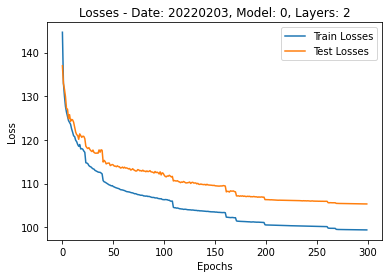

R2 Train: 0.4078936074715317, R2 Test: 0.3902048919150265
Model Number: 1
Num Layers: 3, Hidden Layer Dimensionality: 35, Total Parameters: 5294
Epoch: 000, LR: 0.010000, Train Loss: 143.9505013, Test Loss: 135.9138955
Epoch: 050, LR: 0.007000, Train Loss: 108.3773697, Test Loss: 112.0622902
Epoch: 100, LR: 0.003430, Train Loss: 100.5711188, Test Loss: 105.9429855
Epoch: 150, LR: 0.001176, Train Loss: 96.6567095, Test Loss: 102.4816960
Epoch: 200, LR: 0.000824, Train Loss: 95.1541609, Test Loss: 101.3755119
Epoch: 250, LR: 0.000282, Train Loss: 94.1612995, Test Loss: 100.5876742
Time to train model: 264.8969666957855


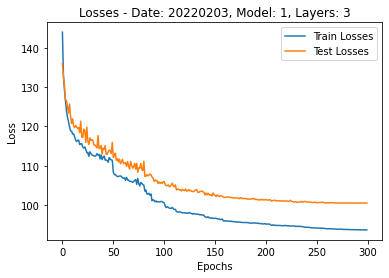

R2 Train: 0.4413219766762218, R2 Test: 0.41805498895184245
Model Number: 2
Num Layers: 4, Hidden Layer Dimensionality: 35, Total Parameters: 6554
Epoch: 000, LR: 0.010000, Train Loss: 145.3632560, Test Loss: 136.4071065
Epoch: 050, LR: 0.007000, Train Loss: 103.3714733, Test Loss: 107.9734420
Epoch: 100, LR: 0.001681, Train Loss: 91.3512552, Test Loss: 98.6378473
Epoch: 150, LR: 0.000576, Train Loss: 87.8315651, Test Loss: 95.9486051
Epoch: 200, LR: 0.000097, Train Loss: 86.5832228, Test Loss: 95.7766290
Epoch: 250, LR: 0.000010, Train Loss: 86.2945397, Test Loss: 95.7623067
Time to train model: 297.80578327178955


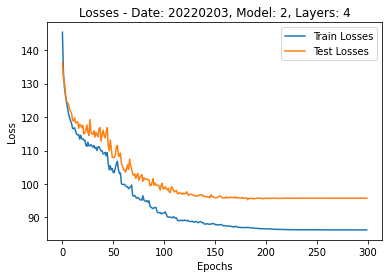

R2 Train: 0.4853977232943415, R2 Test: 0.44598708395905107
Date: 20220210_001
Model Number: 0
Num Layers: 2, Hidden Layer Dimensionality: 35, Total Parameters: 4682
Epoch: 000, LR: 0.010000, Train Loss: 122.2579943, Test Loss: 113.6481844
Epoch: 050, LR: 0.004900, Train Loss: 104.7979303, Test Loss: 103.7527949
Epoch: 100, LR: 0.004900, Train Loss: 103.4224882, Test Loss: 102.4176129
Epoch: 150, LR: 0.001681, Train Loss: 100.8892445, Test Loss: 100.8658058
Epoch: 200, LR: 0.001681, Train Loss: 100.5766511, Test Loss: 100.4784868
Epoch: 250, LR: 0.001176, Train Loss: 100.0514640, Test Loss: 99.9394660
Time to train model: 231.96496319770813


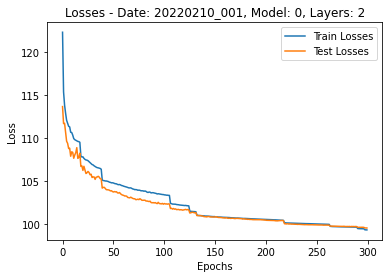

R2 Train: 0.23856945865382972, R2 Test: 0.21977391739077068
Model Number: 1
Num Layers: 3, Hidden Layer Dimensionality: 35, Total Parameters: 5942
Epoch: 000, LR: 0.010000, Train Loss: 123.2112548, Test Loss: 114.4296692
Epoch: 050, LR: 0.004900, Train Loss: 102.0510768, Test Loss: 102.4303677
Epoch: 100, LR: 0.001176, Train Loss: 97.5439671, Test Loss: 99.0726034
Epoch: 150, LR: 0.000824, Train Loss: 96.5903146, Test Loss: 98.1128524
Epoch: 200, LR: 0.000576, Train Loss: 95.9746686, Test Loss: 97.7502821
Epoch: 250, LR: 0.000097, Train Loss: 95.3862465, Test Loss: 97.3220381
Time to train model: 268.00619292259216


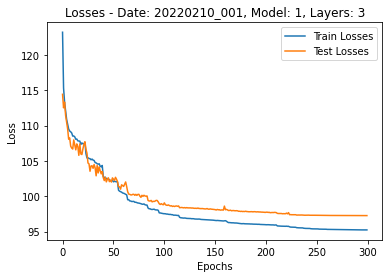

R2 Train: 0.2696467748846935, R2 Test: 0.23823213132364696
Model Number: 2
Num Layers: 4, Hidden Layer Dimensionality: 35, Total Parameters: 7202
Epoch: 000, LR: 0.010000, Train Loss: 125.2930012, Test Loss: 115.5448474
Epoch: 050, LR: 0.004900, Train Loss: 101.9943874, Test Loss: 102.0904162
Epoch: 100, LR: 0.001681, Train Loss: 97.5001160, Test Loss: 99.9119019
Epoch: 150, LR: 0.000282, Train Loss: 95.5393358, Test Loss: 98.4869421
Epoch: 200, LR: 0.000033, Train Loss: 95.1456434, Test Loss: 98.3035251
Epoch: 250, LR: 0.000010, Train Loss: 95.0829555, Test Loss: 98.2767577
Time to train model: 300.8619921207428


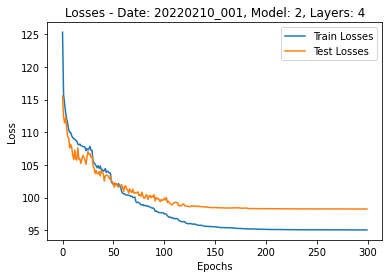

R2 Train: 0.27098792255509285, R2 Test: 0.23011227361832598
Date: 20220210_002
Model Number: 0
Num Layers: 2, Hidden Layer Dimensionality: 35, Total Parameters: 4682
Epoch: 000, LR: 0.010000, Train Loss: 128.8615272, Test Loss: 120.4382852
Epoch: 050, LR: 0.007000, Train Loss: 109.2024056, Test Loss: 110.1237039
Epoch: 100, LR: 0.007000, Train Loss: 108.1332632, Test Loss: 108.5868852
Epoch: 150, LR: 0.003430, Train Loss: 105.4494879, Test Loss: 106.6662246
Epoch: 200, LR: 0.000824, Train Loss: 103.6791982, Test Loss: 105.5908745
Epoch: 250, LR: 0.000282, Train Loss: 103.1787380, Test Loss: 105.4015947
Time to train model: 229.89068984985352


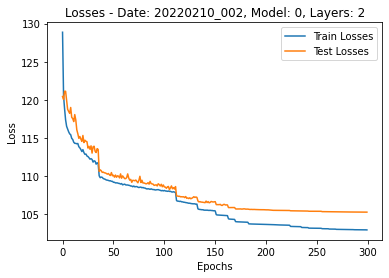

R2 Train: 0.28039153599904376, R2 Test: 0.2691021721438829
Model Number: 1
Num Layers: 3, Hidden Layer Dimensionality: 35, Total Parameters: 5942
Epoch: 000, LR: 0.010000, Train Loss: 129.5530985, Test Loss: 123.7047125
Epoch: 050, LR: 0.003430, Train Loss: 103.6090469, Test Loss: 104.5304898
Epoch: 100, LR: 0.002401, Train Loss: 101.3185006, Test Loss: 102.2879230
Epoch: 150, LR: 0.000404, Train Loss: 99.1051372, Test Loss: 100.6912726
Epoch: 200, LR: 0.000138, Train Loss: 98.6846535, Test Loss: 100.3891503
Epoch: 250, LR: 0.000011, Train Loss: 98.5159139, Test Loss: 100.3262089
Time to train model: 269.02747988700867


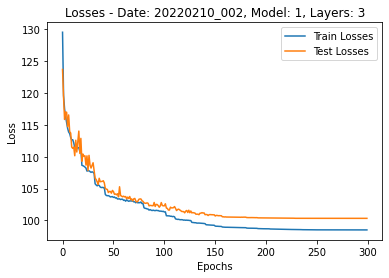

R2 Train: 0.3114777813155082, R2 Test: 0.3035469814100089
Model Number: 2
Num Layers: 4, Hidden Layer Dimensionality: 35, Total Parameters: 7202
Epoch: 000, LR: 0.010000, Train Loss: 129.7597625, Test Loss: 121.0907873
Epoch: 050, LR: 0.003430, Train Loss: 102.3301875, Test Loss: 104.1155570
Epoch: 100, LR: 0.001176, Train Loss: 97.9355224, Test Loss: 101.1447640
Epoch: 150, LR: 0.000198, Train Loss: 96.6083575, Test Loss: 99.8406759
Epoch: 200, LR: 0.000023, Train Loss: 96.2400584, Test Loss: 99.6697049
Epoch: 250, LR: 0.000010, Train Loss: 96.2022297, Test Loss: 99.6559732
Time to train model: 304.16337156295776


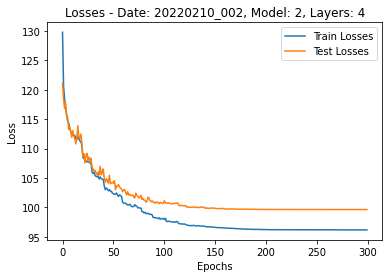

R2 Train: 0.32767329592997396, R2 Test: 0.3088401892140956
Date: 20220224
Model Number: 0
Num Layers: 2, Hidden Layer Dimensionality: 35, Total Parameters: 6338
Epoch: 000, LR: 0.010000, Train Loss: 113.4175912, Test Loss: 109.2526050
Epoch: 050, LR: 0.007000, Train Loss: 102.1190590, Test Loss: 103.0003757
Epoch: 100, LR: 0.002401, Train Loss: 100.1758984, Test Loss: 100.5833915
Epoch: 150, LR: 0.001681, Train Loss: 99.7066426, Test Loss: 100.1786030
Epoch: 200, LR: 0.000198, Train Loss: 99.1056344, Test Loss: 99.7377637
Epoch: 250, LR: 0.000011, Train Loss: 99.0099955, Test Loss: 99.7092771
Time to train model: 251.44673562049866


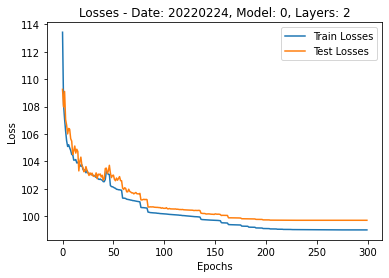

R2 Train: 0.10209846002675886, R2 Test: 0.09974715920583485
Model Number: 1
Num Layers: 3, Hidden Layer Dimensionality: 35, Total Parameters: 7598
Epoch: 000, LR: 0.010000, Train Loss: 113.1856623, Test Loss: 109.0906874
Epoch: 050, LR: 0.004900, Train Loss: 97.4341474, Test Loss: 97.7887894
Epoch: 100, LR: 0.001681, Train Loss: 94.8796018, Test Loss: 95.8223885
Epoch: 150, LR: 0.000576, Train Loss: 93.9164688, Test Loss: 95.0111100
Epoch: 200, LR: 0.000282, Train Loss: 93.6098334, Test Loss: 94.6389605
Epoch: 250, LR: 0.000047, Train Loss: 93.4109399, Test Loss: 94.5039979
Time to train model: 282.9642255306244


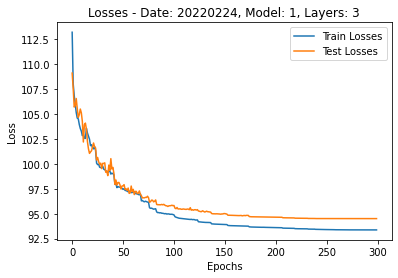

R2 Train: 0.15319604025143285, R2 Test: 0.14654928804791548
Model Number: 2
Num Layers: 4, Hidden Layer Dimensionality: 35, Total Parameters: 8858
Epoch: 000, LR: 0.010000, Train Loss: 113.5835283, Test Loss: 111.9689179
Epoch: 050, LR: 0.004900, Train Loss: 99.3906463, Test Loss: 99.5273949
Epoch: 100, LR: 0.001681, Train Loss: 96.1347748, Test Loss: 96.6179419
Epoch: 150, LR: 0.000404, Train Loss: 94.6619389, Test Loss: 95.8213666
Epoch: 200, LR: 0.000138, Train Loss: 94.2861088, Test Loss: 95.5211361
Epoch: 250, LR: 0.000010, Train Loss: 94.1372878, Test Loss: 95.4820283
Time to train model: 320.4848687648773


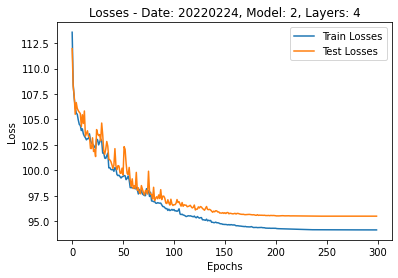

R2 Train: 0.14634991881319606, R2 Test: 0.1378747405306246


In [ ]:
all_instance_data = []

r2_train_list = []
r2_test_list = []
pr2_train_list = []
pr2_test_list = []

for j, (train_loader, test_loader) in enumerate(zip(train_loader_list, test_loader_list)):

    print('Date: {}'.format(dataset_list[j].date))
    models_list = [FCNet(input_dim = 69, output_dim=dataset_list[j].num_neural_units, num_layers = 2, hidden_layer_dim = 35).to(device),\
                   FCNet(input_dim = 69, output_dim=dataset_list[j].num_neural_units, num_layers = 3, hidden_layer_dim = 35).to(device),\
                   FCNet(input_dim = 69, output_dim=dataset_list[j].num_neural_units, num_layers = 4, hidden_layer_dim = 35).to(device)]

    model_instance_data = []
    r2_model_train_list = []
    r2_model_test_list = []
    for i, model in enumerate(models_list):
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5, min_lr=0.00001)   
        total_params = sum(p.numel() for p in model.parameters())

        print('Model Number: {}'.format(i))
        print('Num Layers: {}, Hidden Layer Dimensionality: {}, Total Parameters: {}'\
            .format(model.num_layers, model.hidden_layer_dim, total_params))

        train_losses = []
        val_losses = []
        test_losses = []
        start = time.time()
        for epoch in range(300):
            # print(epoch)
            lr = scheduler.optimizer.param_groups[0]['lr']
            train_loss = train(train_loader, model, optimizer, criterion)
            test_loss = test(test_loader, model, optimizer, criterion)
            scheduler.step(test_loss)
            if epoch % 50==0:
                print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}, Test Loss: {:.7f}'\
                      .format(epoch, lr, train_loss, test_loss))
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        end = time.time()
        print('Time to train model: {}'.format(end-start))
        plt.plot(train_losses)
        plt.plot(test_losses)
        plt.title('Losses - Date: {}, Model: {}, Layers: {}'.format(dataset_list[j].date, i, model.num_layers))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(['Train Losses', 'Test Losses'])
        plt.show()

        train_instance_data = get_instance_losses(train_loader, model)
        test_instance_data = get_instance_losses(test_loader, model)
        instance_data = [train_instance_data, test_instance_data]

        r2_train = sklearn.metrics.r2_score(train_instance_data[2],train_instance_data[3],multioutput='variance_weighted')
        r2_test = sklearn.metrics.r2_score(test_instance_data[2],test_instance_data[3],multioutput='variance_weighted')
        # pr2_train = get_pr2(train_instance_data[2],train_instance_data[3])
        # pr2_test = get_pr2(test_instance_data[2],test_instance_data[3])
        print('R2 Train: {}, R2 Test: {}'.format(r2_train, r2_test))

        r2_model_train_list.append(r2_train)
        r2_model_test_list.append(r2_test)
        # pr2_train_list.append(pr2_train)
        # pr2_test_list.append(pr2_test)

        # save model
        directory = '/content/drive/My Drive/Miller_Lab/FIU/MLP/Pop_FreeReaching_Jarvis/Centered_Smoothed_3DKeypoints/'
        model_name = 'date{}_layers{}.pth'.format(dataset_list[j].date, model.num_layers)
        torch.save(model.state_dict(), directory+model_name)
        
    r2_train_list.append(r2_model_train_list)
    r2_test_list.append(r2_model_test_list)

In [ ]:
for i, (r2_train_model_list, r2_test_model_list) in enumerate(zip(r2_train_list, r2_test_list)):
    print('Date: {}'.format(dataset_list[i].date))
    r2_list = [r2_train_model_list, r2_test_model_list]
    df = pd.DataFrame (r2_list, columns = ['2 layers','3 layers','4 layers'], index = ['Train','Test'])
    display(df)
    print('\n')

Date: 20220203


,2 layers,3 layers,4 layers
Train,0.407894,0.441322,0.485398
Test,0.390205,0.418055,0.445987




Date: 20220210_001


,2 layers,3 layers,4 layers
Train,0.238569,0.269647,0.270988
Test,0.219774,0.238232,0.230112




Date: 20220210_002


,2 layers,3 layers,4 layers
Train,0.280392,0.311478,0.327673
Test,0.269102,0.303547,0.308840




Date: 20220224


,2 layers,3 layers,4 layers
Train,0.102098,0.153196,0.146350
Test,0.099747,0.146549,0.137875


# GLM Baseline

In [ ]:
# [dataset][tuple][input/output]
glm_train_inputs = []
glm_train_targets = []
for i in range(len(train_joint_velocities_dataset_list)):
    dataset = train_joint_velocities_dataset_list[i]
    inputs = []
    targets = []
    for j in range(len(dataset)):
        tup = dataset[j]
        inp = tup[0]
        target = tup[1]
        inputs.append(inp)
        targets.append(target)
    dataset_inputs = np.hstack(inputs).T
    dataset_targets = np.vstack(targets)
    glm_train_inputs.append(dataset_inputs)
    glm_train_targets.append(dataset_targets)

In [ ]:
glm_test_inputs = []
glm_test_targets = []
for i in range(len(test_joint_velocities_dataset_list)):
    dataset = test_joint_velocities_dataset_list[i]
    inputs = []
    targets = []
    for j in range(len(dataset)):
        tup = dataset[j]
        inp = tup[0]
        target = tup[1]
        inputs.append(inp)
        targets.append(target)
    dataset_inputs = np.hstack(inputs).T
    dataset_targets = np.vstack(targets)
    glm_test_inputs.append(dataset_inputs)
    glm_test_targets.append(dataset_targets)

In [ ]:
len(glm_train_inputs), len(glm_train_targets), len(glm_test_inputs), len(glm_test_targets)

(4, 4, 4, 4)

In [ ]:
glm_train_inputs[0].shape, glm_train_targets[0].shape, glm_test_inputs[0].shape, glm_test_targets[0].shape

((14400, 15), (14400, 44), (3600, 15), (3600, 44))

In [ ]:
/content/drive/MyDrive/Miller_Lab/FIU/PopFR_Jarvis/

/content


In [ ]:
from google.colab import files

In [ ]:
io.savemat('/content/20220203_data.mat',dict(train_x=glm_train_inputs[0], train_y=glm_train_targets[0], test_x=glm_test_inputs[0], test_y=glm_test_targets[0]))
io.savemat('/content/20220210_001_data.mat',dict(train_x=glm_train_inputs[1], train_y=glm_train_targets[1], test_x=glm_test_inputs[1], test_y=glm_test_targets[1]))
io.savemat('/content/20220210_002_data.mat',dict(train_x=glm_train_inputs[2], train_y=glm_train_targets[2], test_x=glm_test_inputs[2], test_y=glm_test_targets[2]))
io.savemat('/content/20220224_data.mat',dict(train_x=glm_train_inputs[3], train_y=glm_train_targets[3], test_x=glm_test_inputs[3], test_y=glm_test_targets[3]))

In [ ]:
print('Poisson GLM Results')
for n in range(len(glm_train_inputs)):
    train_targ_n = glm_train_targets[n]
    train_inp_n = glm_train_inputs[n]

    test_targ_n = glm_test_targets[n]
    test_inp_n = glm_test_inputs[n]

    train_pr2_list = []
    test_pr2_list = []

    for i in range(train_targ_n.shape[1]):
        glm_poisson = sm.GLM(train_targ_n[:,i], train_inp_n, family=sm.families.Poisson())
        res = glm_poisson.fit()
        train_pred = glm_poisson.predict(res.params, exog=train_inp_n)
        test_pred = glm_poisson.predict(res.params, exog=test_inp_n)
        train_pr2_list.append(get_pr2(train_targ_n[:,i], train_pred))
        test_pr2_list.append(get_pr2(test_targ_n[:,i], test_pred))
    train_avg_pr2 = sum(train_pr2_list)/len(train_pr2_list)
    test_avg_pr2 = sum(test_pr2_list)/len(test_pr2_list)
    print('Average Train pR2 for {} dataset: {}'.format(dataset_list[n].date, train_avg_pr2))
    print('Average Test pR2 for {} dataset: {}'.format(dataset_list[n].date, test_avg_pr2))
    print('\n')

Poisson GLM Results
Average Train pR2 for 20220203 dataset: -3.7812580204541346
Average Test pR2 for 20220203 dataset: -17.35655134055261


Average Train pR2 for 20220210_001 dataset: -7.970920949817034
Average Test pR2 for 20220210_001 dataset: -7.441614735689414


Average Train pR2 for 20220210_002 dataset: -6.218056646483844
Average Test pR2 for 20220210_002 dataset: -6.940678958363681


Average Train pR2 for 20220224 dataset: -5.672331335454482
Average Test pR2 for 20220224 dataset: -5.516034881302636




# OpenSIM

In [ ]:
import scipy.io
mat_20220405 = scipy.io.loadmat('20220405_Pop_FR_002_unsorted_binned_smoothed.mat')

In [ ]:
mat_20220309 = scipy.io.loadmat('20220309_Pop_FR_002_unsorted_binned_smoothed.mat')

In [ ]:
input = mat_20220309['data'][0][0][-4]
output = mat_20220309['data'][0][0][-1]

In [ ]:
input.shape, output.shape

((17969, 24), (17969, 96))

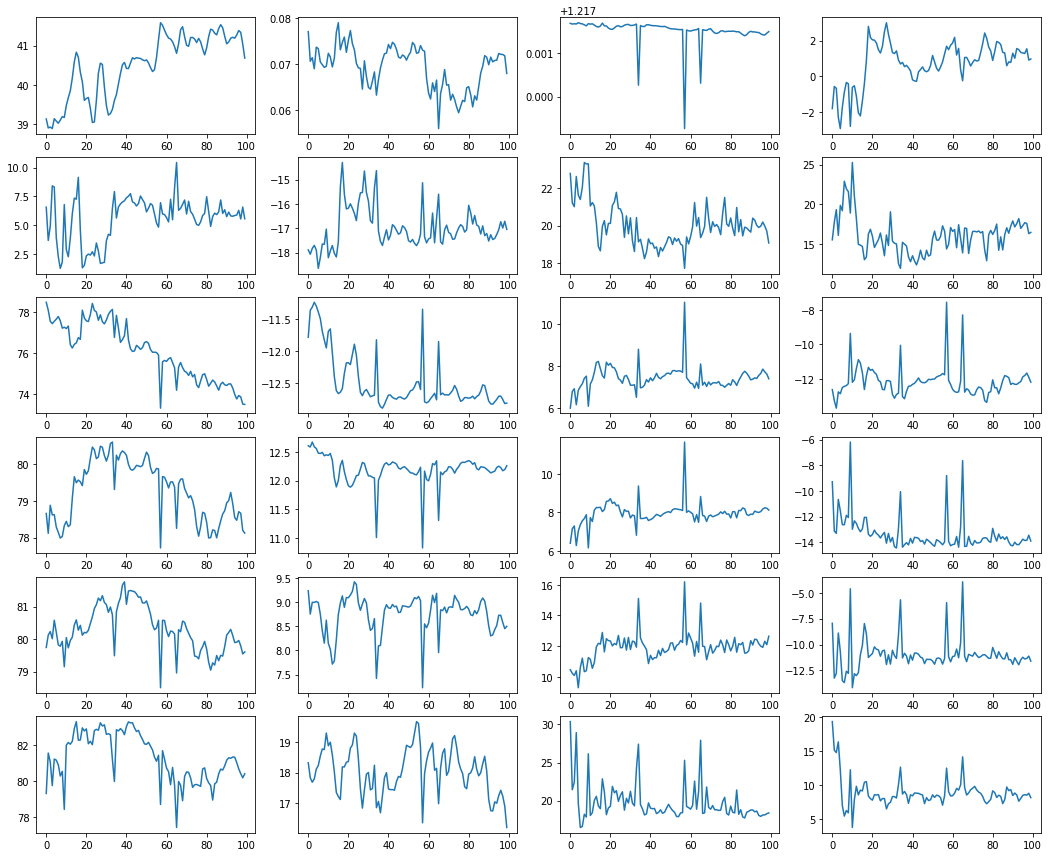

In [ ]:
f, ax = plt.subplots(nrows = 6, ncols = 4)
f.set_size_inches(18, 15)
for k in range(24):
    i = k-(int(k/4)*4)
    j = int(k/4)
    ax[j][i].plot(input[:100,k])
plt.show()

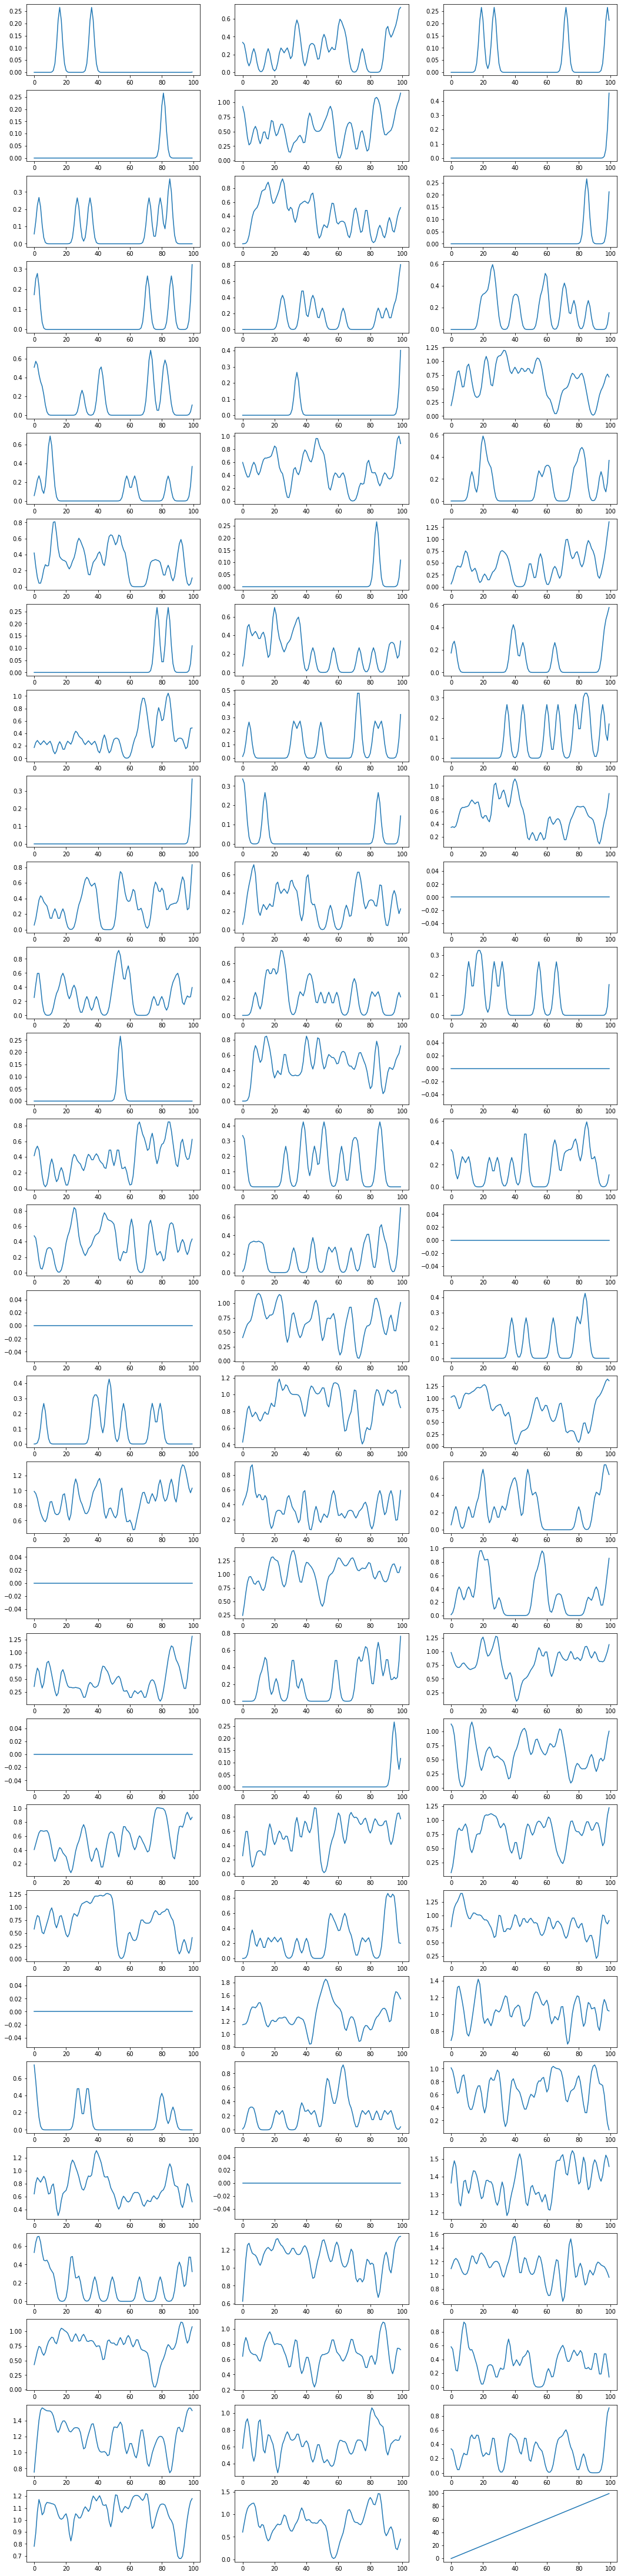

In [ ]:
nrows,ncols=30,3
f, ax = plt.subplots(nrows, ncols)
f.set_size_inches(18, 80)
for k in range(nrows*ncols):
    i = k-(int(k/ncols)*ncols)
    j = int(k/ncols)
    if k==nrows*ncols-1:
        ax[j][i].plot(np.arange(100))
    else:
        ax[j][i].plot(output[:100,k])
plt.show()

In [ ]:
class OSIMDataset(Dataset):
    def __init__(self, input, neuraldata, shuffle = False):
        # self.date = date
        self.inputs = input
        self.input_dim = self.inputs.shape[-1]
        #remove last instance, as neural data has 1 too many instances after binning/smoothing
        self.num_neural_units = neuraldata.shape[1]
        self.neuraloutputs = neuraldata
        self.sample_nums = np.arange(len(self.inputs))

        def shuffle_data(inputs, targets, samp_nums):
            assert len(inputs) == len(targets)
            p = np.random.permutation(len(inputs))
            return(inputs[p], targets[p], samp_nums[p])

        if shuffle == True:
            self.inputs, self.neuraloutputs, self.sample_nums = \
              shuffle_data(self.inputs, self.neuraloutputs, self.sample_nums)

    def __len__(self):
        assert len(self.inputs) == len(self.neuraloutputs)
        return len(self.inputs)

    def __getitem__(self, idx):
        input = torch.from_numpy(self.inputs[idx])
        neuraloutput = torch.from_numpy(self.neuraloutputs[idx])
        sample_num = self.sample_nums[idx]
        #input is transposed for convenience - better for Conv1D
        return input.float(), neuraloutput.float(), sample_num

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.num_layers = 2
        self.hidden_layer_dim = hidden_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        # self.fc1 = nn.Linear(input_size, output_size)
        self.relu = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
osim_dataset_20220309 = OSIMDataset(input, output, shuffle = False)

In [ ]:
osim_dataset_20220309[0][0].shape, osim_dataset_20220309[0][1].shape

(torch.Size([24]), torch.Size([96]))

In [ ]:
num_instances = len(osim_dataset_20220309)
train_split = int(num_instances*.8)

osim_train_dataset = Subset(osim_dataset_20220309, np.arange(num_instances)[:train_split])
osim_test_dataset = Subset(osim_dataset_20220309, np.arange(num_instances)[train_split:])
osim_toy_dataset = Subset(osim_dataset_20220309, np.arange(num_instances)[:4])

osim_train_loader = torch.utils.data.DataLoader(osim_train_dataset, batch_size=32, pin_memory=True, sampler=None)
osim_test_loader = torch.utils.data.DataLoader(osim_test_dataset, batch_size=32, pin_memory=True)
osim_toy_loader = torch.utils.data.DataLoader(osim_toy_dataset, batch_size=4, pin_memory=True)

In [ ]:
def get_pr2_osim(real_data, predictions, lam = 0, EPS = 0.000001):
    predictions[predictions==0]=0.0000001
    m = np.mean(real_data, axis = 0)+EPS

    d1 = real_data/predictions
    d2 = real_data/m

    d1[d1==0]=0.0000001
    d2[d2==0]=0.0000001

    a1=(real_data*np.log(d1))-(real_data-predictions)
    a2=(real_data*np.log(d2))-(real_data-m)

    sum1 = np.sum(a1, axis = 0)
    sum2 = np.sum(a2, axis = 0)

    sum2[sum2==0]=EPS
    pR2 = 1 - (sum1/sum2)
    return(np.mean(pR2))

Model Number: 0
Num Layers: 2, Hidden Layer Dimensionality: 70, Total Parameters: 8069
Epoch: 000, LR: 0.010000, Train Loss: 0.0621999, Test Loss: 0.0548886
Epoch: 050, LR: 0.003430, Train Loss: 0.0449643, Test Loss: 0.0460370
Epoch: 100, LR: 0.001176, Train Loss: 0.0442484, Test Loss: 0.0454700
Epoch: 150, LR: 0.000198, Train Loss: 0.0439082, Test Loss: 0.0451848
Epoch: 200, LR: 0.000011, Train Loss: 0.0438360, Test Loss: 0.0451783
Epoch: 250, LR: 0.000010, Train Loss: 0.0438338, Test Loss: 0.0451782
Time to train model: 249.96082615852356


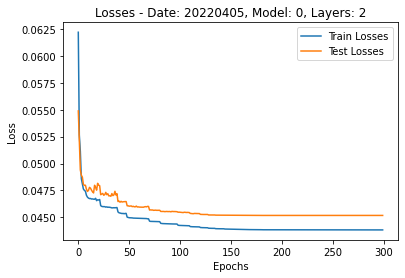

R2 Train: 0.2939452968686537, R2 Test: 0.2809707940243715
pR2 Train: -2.055180549621582, pR2 Test: -2.071855068206787
Model Number: 1
Num Layers: 3, Hidden Layer Dimensionality: 70, Total Parameters: 13039
Epoch: 000, LR: 0.010000, Train Loss: 0.0605335, Test Loss: 0.0564695
Epoch: 050, LR: 0.007000, Train Loss: 0.0489100, Test Loss: 0.0499084
Epoch: 100, LR: 0.001176, Train Loss: 0.0464348, Test Loss: 0.0487685


KeyboardInterrupt: ignored

In [ ]:
models_list = [FCNet(input_dim = 24, output_dim=89, num_layers = 2, hidden_layer_dim = 70, add_relu = True).to(device),\
                FCNet(input_dim = 24, output_dim=89, num_layers = 3, hidden_layer_dim = 70, add_relu = True).to(device),\
                FCNet(input_dim = 24, output_dim=89, num_layers = 4, hidden_layer_dim = 70, add_relu = True).to(device)]

model_instance_data = []
r2_model_train_list = []
r2_model_test_list = []
for i, model in enumerate(models_list):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5, min_lr=0.00001)   
    total_params = sum(p.numel() for p in model.parameters())

    print('Model Number: {}'.format(i))
    print('Num Layers: {}, Hidden Layer Dimensionality: {}, Total Parameters: {}'\
        .format(model.num_layers, model.hidden_layer_dim, total_params))

    train_losses = []
    val_losses = []
    test_losses = []
    start = time.time()
    for epoch in range(300):
        lr = scheduler.optimizer.param_groups[0]['lr']
        train_loss = train(osim_train_loader, model, optimizer, criterion)
        test_loss = test(osim_test_loader, model, optimizer, criterion)
        scheduler.step(test_loss)
        if epoch % 50==0:
            print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}, Test Loss: {:.7f}'\
                  .format(epoch, lr, train_loss, test_loss))
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    end = time.time()
    print('Time to train model: {}'.format(end-start))
    plt.plot(train_losses)
    plt.plot(test_losses)
    plt.title('Losses - Date: {}, Model: {}, Layers: {}'.format('20220405', i, model.num_layers))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train Losses', 'Test Losses'])
    plt.show()

    train_instance_data = get_instance_losses(osim_train_loader, model)
    test_instance_data = get_instance_losses(osim_test_loader, model)
    model_instance_data.append([train_instance_data, test_instance_data])

    r2_train = sklearn.metrics.r2_score(train_instance_data[2],train_instance_data[3],multioutput='variance_weighted')
    r2_test = sklearn.metrics.r2_score(test_instance_data[2],test_instance_data[3],multioutput='variance_weighted')
    pr2_train = get_pr2_osim(train_instance_data[2],train_instance_data[3],np.mean(train_instance_data[2]))
    pr2_test = get_pr2_osim(test_instance_data[2],test_instance_data[3],np.mean(test_instance_data[2]))
    print('R2 Train: {}, R2 Test: {}'.format(r2_train, r2_test))
    print('pR2 Train: {}, pR2 Test: {}'.format(pr2_train, pr2_test))

    r2_model_train_list.append(r2_train)
    r2_model_test_list.append(r2_test)
    # pr2_train_list.append(pr2_train)
    # pr2_test_list.append(pr2_test)

    # # save model
    # directory = '/content/drive/My Drive/Miller_Lab/FIU/MLP/Pop_FreeReaching_Jarvis/Smoothed_Joint_Velocities/'
    # model_name = 'date{}_layers{}.pth'.format(dataset_list[j].date, model.num_layers)
    # torch.save(model.state_dict(), directory+model_name)

Model Number: 2
Num Layers: 2, Hidden Layer Dimensionality: 50, Total Parameters: 6146
Epoch: 000, LR: 0.010000, Train Loss: 0.1415191, Test Loss: 0.1327924
Epoch: 050, LR: 0.002401, Train Loss: 0.1105197, Test Loss: 0.1251217
Epoch: 100, LR: 0.001681, Train Loss: 0.1061335, Test Loss: 0.1154605
Epoch: 150, LR: 0.001176, Train Loss: 0.1041436, Test Loss: 0.1103529
Epoch: 200, LR: 0.000824, Train Loss: 0.1028750, Test Loss: 0.1059465
Epoch: 250, LR: 0.000576, Train Loss: 0.1016136, Test Loss: 0.1024960
Time to train model: 290.165545463562


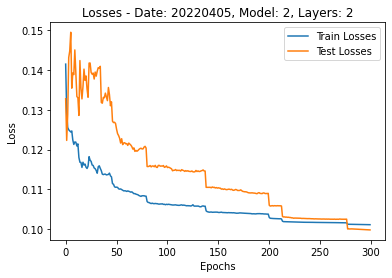

In [ ]:
# model = FCNet(input_dim = 24, output_dim=89, num_layers = 2, hidden_layer_dim = 70, add_relu = True).to(device)

model = MLP(input_size=24, hidden_size=50, output_size=96)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=10, min_lr=0.00001)   
total_params = sum(p.numel() for p in model.parameters())

print('Model Number: {}'.format(i))
print('Num Layers: {}, Hidden Layer Dimensionality: {}, Total Parameters: {}'\
    .format(model.num_layers, model.hidden_layer_dim, total_params))

train_losses = []
val_losses = []
test_losses = []
start = time.time()
for epoch in range(300):
    lr = scheduler.optimizer.param_groups[0]['lr']
    train_loss = train(osim_train_loader, model, optimizer, criterion)
    test_loss = test(osim_test_loader, model, optimizer, criterion)
    scheduler.step(test_loss)
    if epoch % 50==0:
        print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}, Test Loss: {:.7f}'\
              .format(epoch, lr, train_loss, test_loss))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

end = time.time()
print('Time to train model: {}'.format(end-start))
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('Losses - Date: {}, Model: {}, Layers: {}'.format('20220405', i, model.num_layers))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Losses', 'Test Losses'])
plt.show()

In [ ]:
train_instance_data = get_instance_losses(osim_train_loader, model)
test_instance_data = get_instance_losses(osim_test_loader, model)
model_instance_data.append([train_instance_data, test_instance_data])

In [ ]:
train_instance_data[2].shape, train_instance_data[3].shape

((14375, 96), (14375, 96))

In [ ]:
def get_pr2_osim(real_data, predictions, lam = 0, EPS = 0.000001):
    predictions[predictions==0]=0.0000001
    m = np.mean(real_data, axis = 0)+EPS

    d1 = real_data/predictions
    d2 = real_data/m

    d1[d1==0]=0.0000001
    d2[d2==0]=0.0000001

    a1=(real_data*np.log(d1))-(real_data-predictions)
    a2=(real_data*np.log(d2))-(real_data-m)

    sum1 = np.sum(a1, axis = 0)
    sum2 = np.sum(a2, axis = 0)

    sum2[sum2==0]=EPS
    pR2 = 1 - (sum1/sum2)
    return(np.mean(pR2))

In [ ]:
pr2_train = get_pr2_osim(train_instance_data[2],train_instance_data[3])
pr2_test = get_pr2_osim(test_instance_data[2],test_instance_data[3])
print('R2 Train: {}, R2 Test: {}'.format(r2_train, r2_test))
print('pR2 Train: {}, pR2 Test: {}'.format(pr2_train, pr2_test))

R2 Train: 0.2939452968686537, R2 Test: 0.2809707940243715
pR2 Train: nan, pR2 Test: nan


<ipython-input-210-7c55e4ee873f>:11: RuntimeWarning: invalid value encountered in log
  a1=(real_data*np.log(d1))-(real_data-predictions)


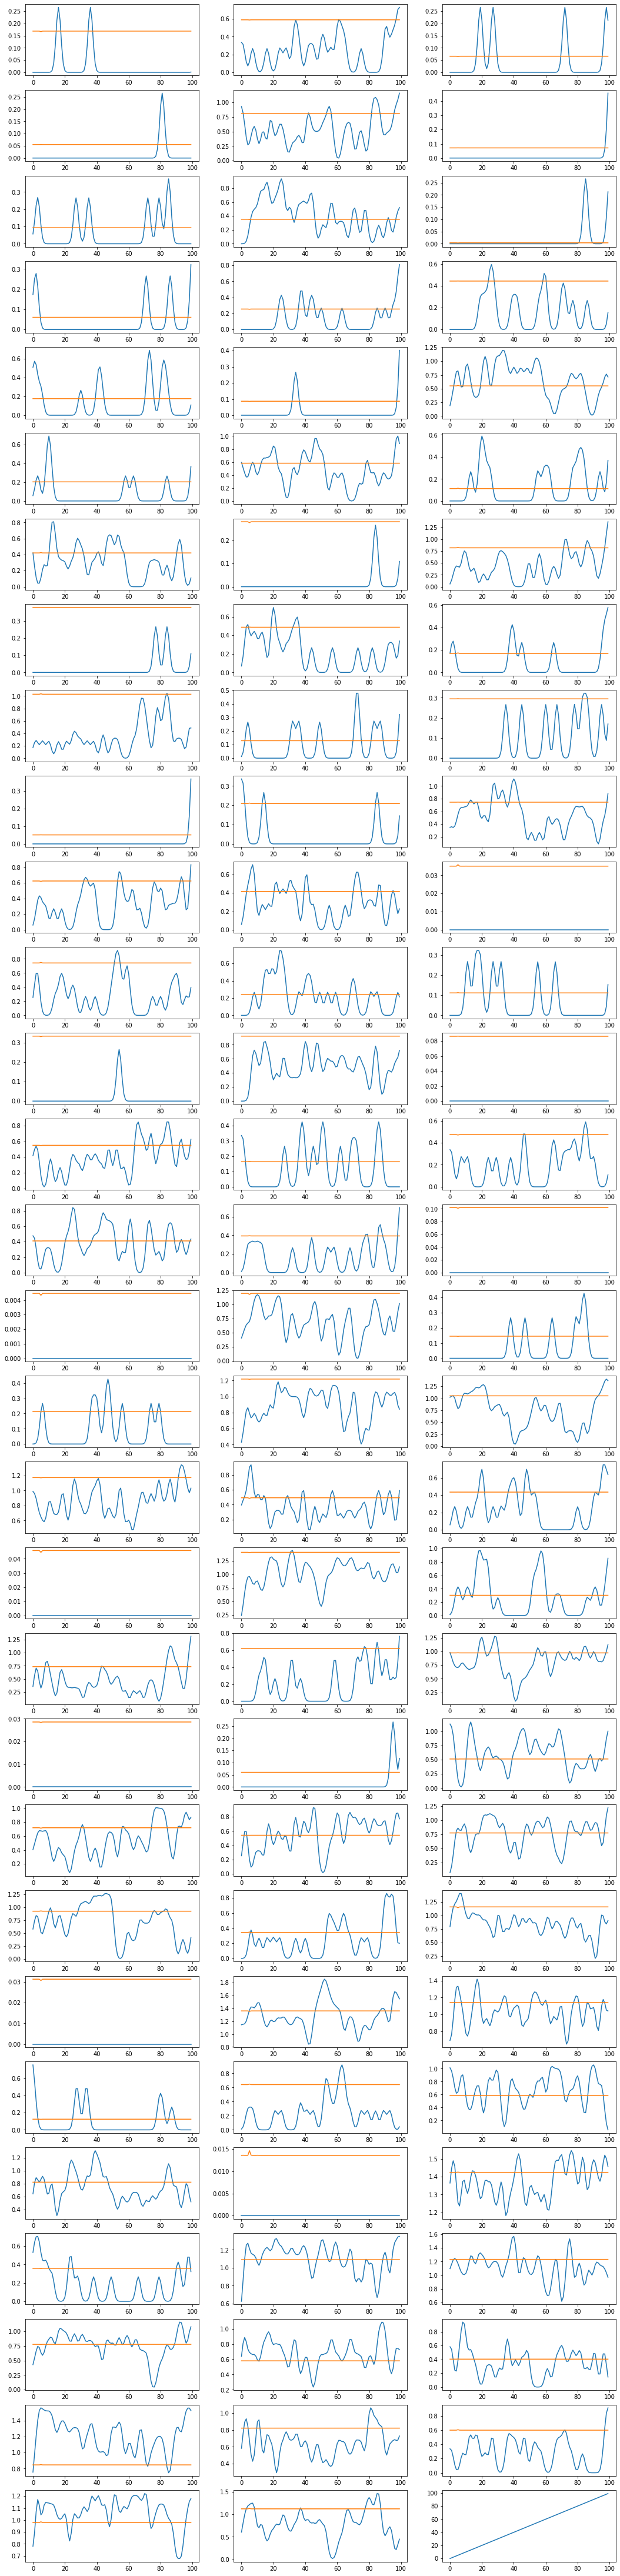

In [ ]:
nrows,ncols=30,3
f, ax = plt.subplots(nrows, ncols)
f.set_size_inches(18, 80)
for k in range(nrows*ncols):
    i = k-(int(k/ncols)*ncols)
    j = int(k/ncols)
    if k==nrows*ncols-1:
        ax[j][i].plot(np.arange(100))
    else:
        ax[j][i].plot(train_instance_data[2][:100,k])
        ax[j][i].plot(train_instance_data[3][:100,k])
plt.show()